<h1><center>Group 2 - Text Mining</center></h1>

## Index

0. [Introduction](#Introduction)
1. [Data Exploration](#Data-Exploration)
2. [Data Preprocessing](#Data-Preprocessing)
    - 2.1   [EXTRA: Expanding Contractions](#Contraction)
    - 2.2   [EXTRA: Converting Emojis to text](#Converting-emojis-text)
    - 2.3   [Stop Words Removal & Punctuation Removal](#Stop-Words-Removal) 
    - 2.4   [EXTRA: Translating Property Descriptions and Host About to English](#Translating-Description-Host-About)
    - 2.5   [Regular Expressions](#Regular-Expressions)
    - 2.6   [Lemmatization](#Lemmatization)
    - 2.7   [Stemming](#Stemming)
    - 2.8   [Creating the Review Length Feature](#Creating-Review-Length-Feature)
    - 2.9  [More Data Exploration](#Data-Exploration-After-Preprocessing)
    - 2.10  [EXTRA: Sentiment Analysis on the Reviews](#Sentiment-Analysis)
    - 2.11  [Train/Validation Split](#Train-Validation-Split)
3. [Feature Engineering](#Feature-Engineering)
    - 3.1  [TF-IDF for Property Description and Host About using Lemmatization](#TF-IDF-LEMMATIZED)
    - 3.2  [TF-IDF for Property Description and Host About using Stemming](#TF-IDF-STEMMED)
    - 3.3  [GloVe Embeddings for Property Description and Host About](#GloVe-Embeddings)
    - 3.4  [EXTRA: Sentence Embeddings on the Reviews, using BERT BASE Multilingual Model (Uncased)](#BERT-BASE-MULTI-UNCASED)
    - 3.5  [EXTRA: Sentence Embeddings on the Reviews, using XLM-RoBERTa (base-sized model)](#XLM-ROBERTA-BASE) 
4. [Classification Models and Evaluation](#Classification-Models)
    - 4.1  [K-Nearest Neighbour with TF-IDF (Lemmatizated Version)](#KNN-LEMMATIZED)
    - 4.2  [K-Nearest Neighbour with TF-IDF (Stemming Version)](#KNN-STEMMED)
    - 4.3  [Logistic Regression with TF-IDF (Lemmatized Version)](#LR)
    - 4.4  [Long-Short Term Memory using GloVe Embeddings](#LSTM)
    - 4.5  [EXTRA: Random Forest using Sentence Embeddings BERT Multilingual, Sentiment Analysis, Number of Reviews](#RF-1)
    - 4.6  [EXTRA: Random Forest using Sentence Embeddings XLM-RoBERTa (base-sized model), Sentiment Analysis, Number of Reviews](#RF-2)
    - 4.7  [EXTRA: Stacking Ensemble Classifier](#Ensemble)
5. [Predictions on the Test Data](#Final-Predictions)
6. [Conclusion](#Conclusion)

| Student Names | Student Number |
|--------------|----------------|
| Guilherme Sá           | 20230520               |
| Helena Mashayekhi      | 20230561               |
| Raquel Rocha           | 20230188
| Sebastião Rosalino           | 20230372               | 20230372@novaims.unl.pt              |

<div style="background-color: yellow; color: black; padding: 10px;">
    <b>WARNING:</b> This notebook takes approximately 17.65 hours to totally execute
</div>

<a id='Introduction'></a>
# 0. Introduction

<a id='Data-Exploration'></a>
# 1. Data Exploration

In [2]:
# Import the necessary libraries and configurations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import html
import emoji
import contractions
import pycountry
import nltk
import spacy
import optuna
import torch
import plotly.express as px
import langdetect
import tqdm
import torchtext.vocab as vocab

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer

from wordcloud import WordCloud

from gensim.models import Word2Vec, FastText, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, GRU, Input, Concatenate, Flatten, Masking, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate, Dropout, Flatten, Input, LSTM, Reshape

from transformers import pipeline, BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel, XLMRobertaTokenizer, XLMRobertaModel

from deep_translator import GoogleTranslator
from spellchecker import SpellChecker

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load all datasets
train = pd.read_excel("train.xlsx")
train_reviews = pd.read_excel("train_reviews.xlsx")
test = pd.read_excel("test.xlsx")
test_reviews = pd.read_excel("test_reviews.xlsx")

In [4]:
# Check the first 3 rows of the train dataset
train.head(3)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1


In [5]:
# Rename the column 'index' of train to 'property_id'
train.rename(columns={"index": "property_id"}, inplace=True)
train.head(3)

,property_id,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  6248 non-null   int64 
 1   description  6248 non-null   object
 2   host_about   6248 non-null   object
 3   unlisted     6248 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.4+ KB


In [7]:
# Check the first 3 rows of the train_reviews dataset
train_reviews.head(3)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [8]:
# Rename the column 'index' of train_reviews to 'property_id'
train_reviews.rename(columns={"index": "property_id"}, inplace=True)
train_reviews.head(3)

,property_id,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [9]:
train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   property_id  361281 non-null  int64 
 1   comments     361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [10]:
# Eliminate the 2 records with null comments
train_reviews = train_reviews.dropna(subset=['comments'])

In [11]:
# Check the first 3 rows of the test dataset
test.head(3)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."


In [12]:
# Rename the column 'index' of test to 'property_id'
test.rename(columns={"index": "property_id"}, inplace=True)
test.head(3)

,property_id,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  695 non-null    int64 
 1   description  695 non-null    object
 2   host_about   695 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.4+ KB


In [14]:
# Check the first 3 rows of the test_reviews dataset
test_reviews.head(3)

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...


In [15]:
# Rename the column 'index' of test_reviews to 'property_id'
test_reviews.rename(columns={"index": "property_id"}, inplace=True)
test_reviews.head(3)

,property_id,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...


In [16]:
test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41866 entries, 0 to 41865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  41866 non-null  int64 
 1   comments     41866 non-null  object
dtypes: int64(1), object(1)
memory usage: 654.3+ KB


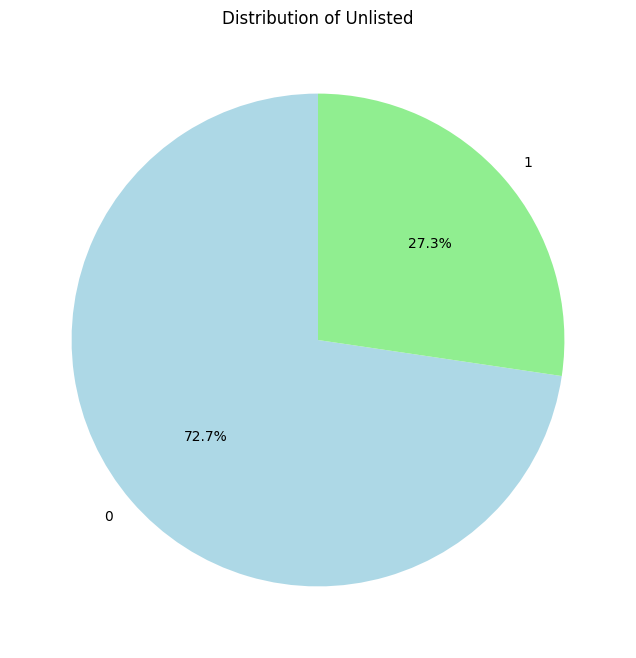

In [17]:
# Check the distribution of the target 'unlisted' on the training dataset
unlisted_counts = train['unlisted'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(unlisted_counts, labels=unlisted_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Distribution of Unlisted')
plt.show()

In [39]:
# Merge the train and train_reviews dataset
merged_data = pd.merge(train, train_reviews, on='property_id', how='left')

# Determine if 'comments' mentions 'super host'
merged_data['super_host'] = merged_data['comments'].str.lower().str.contains('super host')

In [40]:
# Check the distribution of the unlisted target when the review contains the expression 'super host'
merged_data[merged_data['super_host'] == True]['unlisted'].value_counts()

unlisted
0    892
1     19
Name: count, dtype: int64

In [41]:
# Check the distribution of the unlisted target when the review does not contain the expression 'super host'
merged_data[merged_data['super_host'] == False]['unlisted'].value_counts()

unlisted
0    345003
1     15365
Name: count, dtype: int64

In [42]:
# Check the distribution of the unlisted target when the review contains the expression 'super host', in percentage
merged_data[merged_data['super_host'] == True]['unlisted'].value_counts(normalize=True) * 100

unlisted
0    97.91438
1     2.08562
Name: proportion, dtype: float64

**As it is possible to conclude from the output above, when the review contains the expression 'super host', it is extremely more likely that the correspondant property will not be unlisted (~98%)** 

In [43]:
# Checking the statistical characteristics of the number of reviews per property
review_counts = train_reviews.groupby('property_id').size().reset_index(name='review_count')
train_with_reviews = train.merge(review_counts, on='property_id', how='left').fillna(0)
train_with_reviews['review_count'].describe()

count    6248.000000
mean       57.823143
std        88.895983
min         0.000000
25%         0.000000
50%        19.000000
75%        76.000000
max       891.000000
Name: review_count, dtype: float64

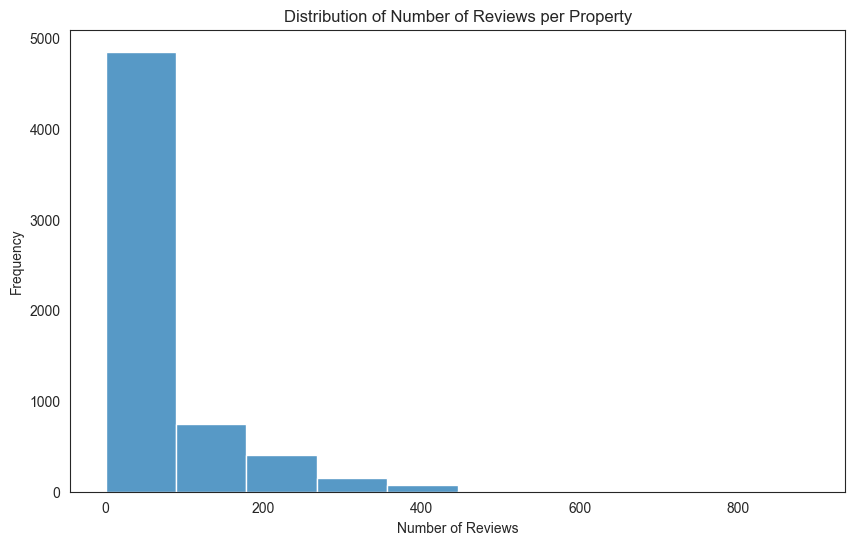

In [44]:
# Plotting the histogram of the distribution of the number of reviews per property
sns.set_style("white")
plt.figure(figsize=(10, 6))  
sns.histplot(train_with_reviews['review_count'], bins=10, kde=False)  
plt.title('Distribution of Number of Reviews per Property')
plt.xlabel('Number of Reviews')  
plt.ylabel('Frequency')  
plt.grid(False) 
plt.show()

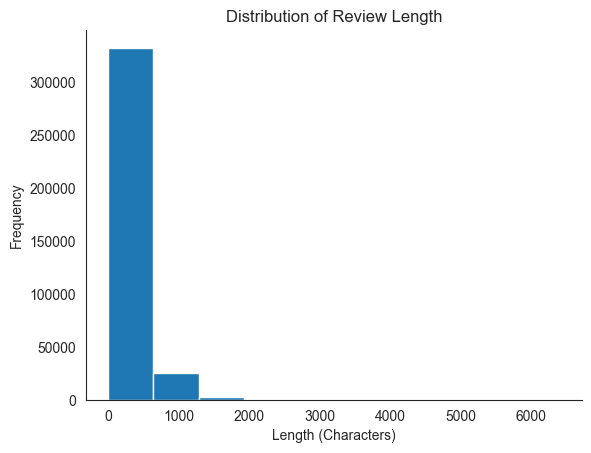

In [45]:
# Plotting the histogram of the distribution of the length of the reviews
train_reviews['comments'].astype(str)
train_reviews['review_length']  = train_reviews['comments'].apply(lambda x: len(str(x)))

train_reviews['review_length'].hist()
plt.grid(False)
plt.title('Distribution of Review Length')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [41]:
# Checking the statistical characteristics of the lengths of the reviews
train_reviews['review_length'].describe()

count    361279.000000
mean        280.513052
std         266.389064
min           1.000000
25%         108.000000
50%         211.000000
75%         368.000000
max        6403.000000
Name: review_length, dtype: float64

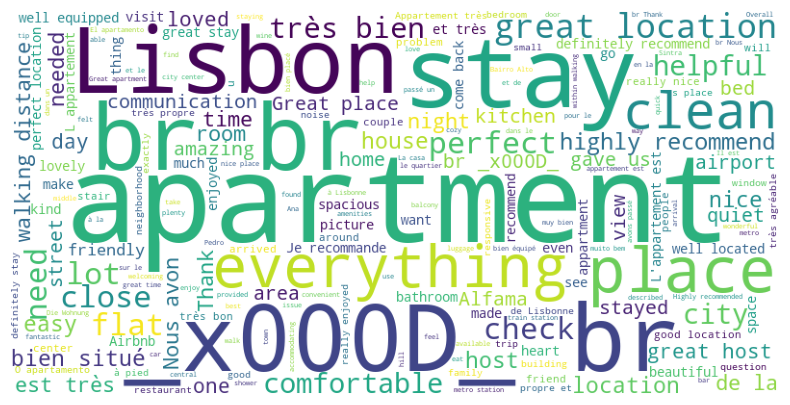

In [42]:
# Plotting the word cloud in the train reviews dataset
train_reviews['comments'] = train_reviews['comments'].astype(str)

all_reviews = ' '.join(train_reviews['comments'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

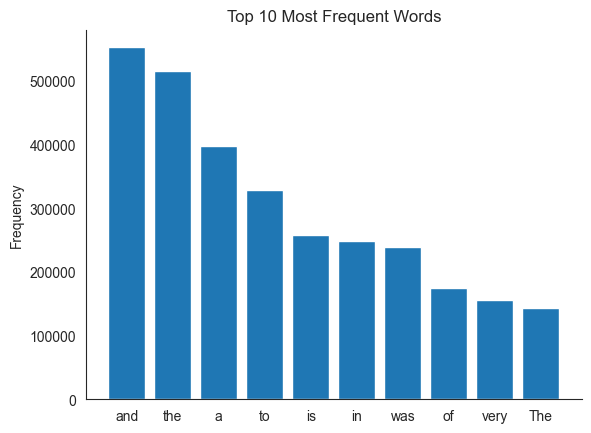

In [43]:
# Check the top 10 most frequent words in the train_reviews dataset
all_words = ' '.join(train_reviews['comments']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]
freq.index[0:10]

x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [44]:
# Check the top 10 least frequent words in the train_reviews dataset
all_words = ' '.join(train_reviews['comments']).split()
freq = pd.Series(all_words).value_counts()
freq = freq.sort_values(ascending=True)
x_labels = freq.index[:10]
values = freq[:10]

values

kitchen/bathroom/etc.                                                             1
investis                                                                          1
accomidating.<br/><br/>I                                                          1
du.<br/>Oso                                                                       1
321                                                                               1
excelente...deu                                                                   1
行李要扛上三楼，自己买的咖啡胶囊，床个人觉得比较软，主人备了加湿器出门开着，总体来说都OK，停车免费，电视可以投屏看手机上的电影囧妈和春晚，主人送了瓶红酒。    1
antigüedades                                                                      1
tulajdonos                                                                        1
segítőkész,                                                                       1
Name: count, dtype: int64

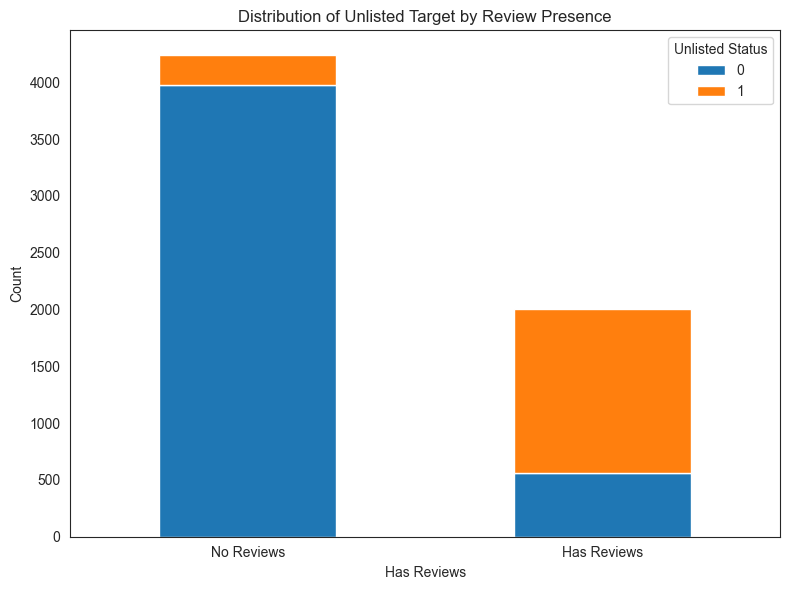

In [45]:
# Check the distribution of the target according to whether a certain property has any reviews or not
properties_with_reviews = train_reviews['property_id'].unique()

# Create a new column in train that indicates whether each property has reviews
train['has_reviews'] = train['property_id'].isin(properties_with_reviews).map({True: 'Has Reviews', False: 'No Reviews'})

# Group data by 'has_reviews' and 'unlisted', and count occurrences
review_distribution = train.groupby(['has_reviews', 'unlisted']).size().unstack(fill_value=0)

# Plot the distribution using a stacked bar plot
review_distribution.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribution of Unlisted Target by Review Presence')
plt.xlabel('Has Reviews')
plt.ylabel('Count')

plt.xticks(ticks=[0, 1], labels=['No Reviews', 'Has Reviews'], rotation=0) 

plt.legend(title='Unlisted Status')
plt.tight_layout()
plt.show()

In [46]:
# Check the frequency of the many languages used in the comments
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'

train_reviews['language'] = train_reviews['comments'].apply(detect_language)
test_reviews['language'] = test_reviews['comments'].apply(detect_language)

In [47]:
# Count the frequency of each language
language_counts = train_reviews['language'].value_counts()

language_counts

language
en         232332
fr          53262
pt          22447
es          19234
de          14209
it           5680
nl           3575
ru           1499
ko           1468
zh-cn        1039
Unknown       918
ro            827
pl            600
ca            578
da            460
sv            372
af            350
no            304
so            272
cs            211
fi            205
id            165
tl            149
hu            136
ja            108
cy            107
he             91
zh-tw          88
hr             82
sw             73
sk             71
tr             66
lt             56
el             49
vi             46
uk             44
sl             36
et             21
bg             18
lv             11
ar              9
sq              8
mk              2
ur              1
Name: count, dtype: int64

In [48]:
# Check the comments that were marked as "Unknown"
train_reviews[train_reviews['language'] == 'Unknown']

,property_id,comments,review_length,language
275,9,.,1,Unknown
432,11,👍,1,Unknown
682,16,.,1,Unknown
822,19,👍,1,Unknown
1129,25,-,1,Unknown
...,...,...,...,...
359217,6209,👌,1,Unknown
359303,6216,.,1,Unknown
359456,6221,1,1,Unknown
359527,6221,5/5,3,Unknown


In [49]:
# Check if there are any duplicated comments
print(f"There are {train_reviews.duplicated().sum()} duplicated reviews")

# Check if there are any duplicated properties
print(f"There are {train.duplicated().sum()} duplicated properties")

There are 141 duplicated reviews
There are 0 duplicated properties


In [50]:
# Export the current train datasets
train.to_csv('train_after_data_exploration.csv')
train_reviews.to_csv('train_reviews_after_data_exploration.csv')

In [51]:
# Export the current test datasets
test.to_csv('test_after_data_exploration.csv')
test_reviews.to_csv('test_reviews_after_data_exploration.csv')

In [49]:
# Load the after data exploration train datasets
train = pd.read_csv('train_after_data_exploration.csv')
train_reviews = pd.read_csv('train_reviews_after_data_exploration.csv')

# Drop unncessary columns created upon reading the datasets
train.drop('Unnamed: 0', axis=1, inplace=True)
train_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [50]:
# Load the after data exploraion test datasets
test = pd.read_csv('test_after_data_exploration.csv')
test_reviews = pd.read_csv('test_reviews_after_data_exploration.csv')

# Drop unncessary columns created upon reading the datasets
test.drop('Unnamed: 0', axis=1, inplace=True)
test_reviews.drop('Unnamed: 0', axis=1, inplace=True)

<a id='Data-Preprocessing'></a>
# 2. Data Preprocessing

<a id='Contraction'></a>
### 2.1. EXTRA: Expanding Contractions

In [51]:
# Find comments with contractions
print(train_reviews['comments'].iloc[302])
print('\n')
print(train_reviews['comments'].iloc[677])

I can't recommend this place enough, it looked amazing in photos but even better in person! There were so many little details that exceeded my every expectation and made the experience absolutely enjoyable.<br/><br/>Will be coming back over and over again!


You can't beat the location, great spot.


In [52]:
# Function to expand the contractions in a text
def expand_contractions(text):
    return contractions.fix(text)

In [53]:
# Apply the function to the comments and to the property description and host about columns, on the train datasets
train_reviews['comments'] = train_reviews['comments'].apply(expand_contractions)
train['description'] = train['description'].apply(expand_contractions)
train['host_about'] = train['host_about'].apply(expand_contractions)

In [54]:
# Check the comments with the expanded contractions
print(train_reviews['comments'].iloc[302])
print('\n')
print(train_reviews['comments'].iloc[677])

I cannot recommend this place enough, it looked amazing in photos but even better in person! There were so many little details that exceeded my every expectation and made the experience absolutely enjoyable.<br/><br/>Will be coming back over and over again!


You cannot beat the location, great spot.


In [55]:
# Apply the function to the comments and to the property description and host about columns, on the test datasets
test_reviews['comments'] = test_reviews['comments'].apply(expand_contractions)
test['description'] = test['description'].apply(expand_contractions)
test['host_about'] = test['host_about'].apply(expand_contractions)

<a id='Converting-emojis-text'></a>
### 2.2. EXTRA: Converting emojis to text 

In [56]:
# Function to replace emojis with their names
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(":", ":"))

# Apply the function to the 'comments' column on the train reviews dataset
train_reviews['comments'] = train_reviews['comments'].apply(replace_emojis)

# Apply the function to the 'description' and 'host_about' columns on the train dataset
train['description'] = train['description'].apply(replace_emojis)
train['host_about'] = train['host_about'].apply(replace_emojis)

In [57]:
# Apply the function to the 'comments' column on the test dataset
test_reviews['comments'] = test_reviews['comments'].apply(replace_emojis)

# Apply the function to the 'description' and 'host_about' columns on the test dataset
test['description'] = test['description'].apply(replace_emojis)
test['host_about'] = test['host_about'].apply(replace_emojis)

<a id='Stop-Words-Removal'></a>
### 2.3. Stop Words Removal & Punctuation Removal

In [58]:
# List of all languages supported by NLTK for stop words removal
supported_languages = stopwords.fileids()

supported_languages

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [59]:
# Creating a dictionary of the language codes and their names to remove the stop words in all the textual columns
lang_map = {
        
    'en': 'english', 'fr': 'french', 'pt': 'portuguese', 'es': 'spanish', 'de': 'german',
    'it': 'italian', 'nl': 'dutch', 'ru': 'russian', 'ko': 'korean',
    'zh-cn': 'chinese', 'Unknown': None, 'ro': 'romanian', 'pl': 'polish',
    'ca': 'catalan', 'da': 'danish', 'sv': 'swedish', 'af': 'afrikaans',
    'no': 'norwegian', 'so': 'somalian', 'cs': 'czech', 'fi': 'finnish',
    'id': 'indonesian', 'tl': 'tagalog', 'hu': 'hungarian', 'ja': 'japanese',
    'cy': 'welsh', 'zh-tw': 'chinese', 'he': 'hebrew', 'hr': 'croatian',
    'sw': 'swahili', 'sk': 'slovak', 'tr': 'turkish', 'lt': 'lithuanian',
    'el': 'greek', 'uk': 'ukrainian', 'sl': 'slovene', 'et': 'estonian',
    'bg': 'bulgarian', 'lv': 'latvian', 'ar': 'arabic', 'sq': 'albanian',
    'mk': 'macedonian', 'ur': 'urdu'
    
}
    
# Create a combined set of all stop words in all languages
all_stop_words = set()
for code, language in lang_map.items():
    if language in stopwords.fileids():
        all_stop_words.update(stopwords.words(language))

# Verify size of the stop words set
print(f"Total stop words collected: {len(all_stop_words)}")

Total stop words collected: 7130


In [60]:
# Inspect all the collected stop words
all_stop_words

{'petindvajsetim',
 '另一方面',
 'petnajsti',
 'niiltä',
 'sedeminšestdesetih',
 '换言之',
 'euer',
 'õk',
 'dog',
 'ذلكم',
 'estaríais',
 'tuyos',
 'diibaratkan',
 'sedmem',
 'zopet',
 'ihres',
 'خامس',
 '呵',
 'dengan',
 'יוכל',
 '倘',
 'arról',
 'mogle',
 'puc',
 'varit',
 'οτι',
 'trikratne',
 'keterlaluan',
 'meu',
 'toţi',
 'par',
 'terdahulu',
 'моя',
 'سوف',
 'je',
 'memang',
 'selaku',
 'ons',
 'todos',
 'šestnajstem',
 '相当',
 'mempertanyakan',
 'vaan',
 'štiridesetemu',
 '分别',
 '严格',
 'su',
 'dar',
 'igen',
 'worden',
 'sendirinya',
 '问题',
 'ποιων',
 '有',
 '各位',
 'étants',
 'sejam',
 '这会儿',
 'بئس',
 '企图',
 'sebagian',
 'mengenai',
 'var',
 'jó',
 '不可',
 'تِه',
 'ὅστισ',
 'mojim',
 'kemungkinan',
 'nostri',
 'اخلولق',
 'non',
 'إي',
 '比如',
 'sedemindvajsetim',
 '伟大',
 'želeli',
 'mampu',
 'ليت',
 'deseterem',
 'marsikaj',
 'inn',
 'fas',
 'γὰρ',
 'moči',
 'petimi',
 'avete',
 'suoi',
 'tisočemu',
 'niye',
 'morate',
 'إلّا',
 'mendatangkan',
 'deci',
 'вот',
 'kakršnimakoli',
 'سبعة',


In [61]:
def remove_global_stop_words(text):

    # Tokenize every text
    words = word_tokenize(text)

    # Remove every word that is present in the set containing all stop words for all suported languages
    filtered_words = [word for word in words if word.lower() not in all_stop_words]
    return ' '.join(filtered_words)

# Apply the above function to remove the stop words in the comments in the 'train_reviews' dataset and in the description and host about 
# columns in the train dataset
train_reviews['comments'] = train_reviews['comments'].apply(remove_global_stop_words)
train['description'] = train['description'].apply(remove_global_stop_words)
train['host_about'] = train['host_about'].apply(remove_global_stop_words)

In [62]:
# Apply the above function to remove the stop words in the comments in the 'test_reviews' dataset and in the description and host about 
# columns in the test dataset
test_reviews['comments'] = test_reviews['comments'].apply(remove_global_stop_words)
test['description'] = test['description'].apply(remove_global_stop_words)
test['host_about'] = test['host_about'].apply(remove_global_stop_words)

In [63]:
def preprocess_text(text):
    
    # If there is no text, return empty string
    if pd.isna(text):
        return ""
    
    # Decode HTML opening and closing tags
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove punctuation and underscores, colons
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'_', ' ', text)
    text = re.sub(r':', '', text)
    
    # Tokenize and convert to lower case
    tokens = word_tokenize(text)
    lower_tokens = [token.lower() for token in tokens]
    
    return ' '.join(lower_tokens)

# Apply the function to the 'comments' column in train_reviews dataset
train_reviews['comments'] = train_reviews['comments'].apply(preprocess_text)

# Apply the function to the train dataset columns
train['description'] = train['description'].apply(preprocess_text)
train['host_about'] = train['host_about'].apply(preprocess_text)

In [64]:
# Apply the function to the 'comments' column in test_reviews dataset
test_reviews['comments'] = test_reviews['comments'].apply(preprocess_text)

# Apply the function to the test dataset columns
test['description'] = test['description'].apply(preprocess_text)
test['host_about'] = test['host_about'].apply(preprocess_text)

In [65]:
# Check the success of all transformations in the train_reviews dataset
train_reviews

,property_id,comments,review_length,language
0,1,cozy comfortable house stay innever worry safe...,156,en
1,1,good,9,cy
2,1,first hostel experience say pretty hard beat p...,1497,en
3,1,hostel neu deshalb funktionierte tadellos schn...,615,de
4,1,fine dorm think people staying far less bathro...,132,en
...,...,...,...,...
361274,6248,location perfect apartment close airport right...,732,en
361275,6248,ana s place exactly described even better easy...,460,en
361276,6248,ana atenciosa preocupou conforto estadia apart...,132,pt
361277,6248,wifi answer wifi connected nobody answered lit...,138,en


In [66]:
# Check the success of all transformations in the train dataset
train

,property_id,description,host_about,unlisted,has_reviews
0,1,shared mixed room hostel shared bathroom locat...,alojamento local registro 20835al,0,Has Reviews
1,2,espaço fica perto parque eduardo vii saldanha ...,friendly host try always around need anything ...,1,No Reviews
2,3,trafaria house cozy familiar villa facilities ...,social person liking communicate reading trave...,1,No Reviews
3,4,apartamento charmoso chiado largo carmo traves...,hello x000d portuguese love meet people around...,0,No Reviews
4,5,joli appartement bordure mer 2 pied plage vue ...,famille deux enfants 17 10 habité pendant plus...,0,Has Reviews
...,...,...,...,...,...
6243,6244,studio 15 new well decorated cozy apartment gr...,brand manager lisbon portugal grew macau south...,0,Has Reviews
6244,6245,lisbon meets cosmopolitan industrial onebedroo...,home feelings visitors let comfort reflect big...,0,Has Reviews
6245,6246,license number exempt,travel agent passionate cultures welcome guest...,1,Has Reviews
6246,6247,campo pequeno prestige classy top quality apar...,família x000d portugal x000d gavião x000d músi...,0,Has Reviews


In [67]:
# Check the success of all transformations in the test_reviews dataset
test_reviews

,property_id,comments,language
0,1,thank much antonio perfect stay appartment per...,en
1,1,nice appartment old town lissabon quite centra...,en
2,1,travelling looking kids friendly places stay a...,en
3,1,lisbon march 2013 3 adults 3 children house bi...,en
4,1,host antonio helpful information lissabon pick...,en
...,...,...,...
41861,695,everything fine,en
41862,695,good located,en
41863,695,appartement confortable conforme photos bien s...,fr
41864,695,très bon logement weekend prolongé lisbonne 4 ...,fr


In [68]:
# Check the success of all transformations in the test dataset
test

,property_id,description,host_about
0,1,space apartment located historic center lisbon...,gosto viajar conhecer pessoas gosto receber am...
1,2,important response covid19 property extended c...,home team count every single detail guarantee ...
2,3,bright beautiful spacious fourbedroom apartmen...,guestready professional property management co...
3,4,charming apartment close bay cascais 1 bedroom...,
4,5,procura umas férias perto praia casino outras ...,bem vindos portugal x000d adoro país adoro con...
...,...,...,...
690,691,brand new apartment xvicentury building amazin...,maria x000d work cinema tv theater tv commerci...
691,692,located iconic streets lisbon enjoy charming a...,guestready professional property management co...
692,693,space studio building renovated 2011 studio br...,hello laetitia means joy latin smile every tim...
693,694,charming apartment overwelming view several di...,alexandra pedro brother sister x000d x000d gre...


<a id='Translate'></a>
### Translate all reviews to English

<a id='Translating-Description-Host-About'></a>
### 2.4. EXTRA: Translating Property Descriptions and Host About to English

In [71]:
records_translated = 0

# Initialize the translator to English
translator = GoogleTranslator(source='auto', target='en')

# Function to translate text
def translate_text(text):
    global records_translated  # Use global keyword to modify the global variable
    if isinstance(text, str) and text.strip() != '':
        try:
            translated_text = translator.translate(text)
            records_translated += 1
            print(f'Translated record {records_translated}')
            return translated_text
        except Exception as e:
            print(f"Error translating text: {e}")
            return text
    else:
        return text

In [84]:
# Apply translation to 'description'
train['description'] = train['description'].apply(translate_text)

Translated record 1
Translated record 2
Translated record 3
Translated record 4
Translated record 5
Translated record 6
Translated record 7
Translated record 8
Translated record 9
Translated record 10
Translated record 11
Translated record 12
Translated record 13
Translated record 14
Translated record 15
Translated record 16
Translated record 17
Translated record 18
Translated record 19
Translated record 20
Translated record 21
Translated record 22
Translated record 23
Translated record 24
Translated record 25
Translated record 26
Translated record 27
Translated record 28
Translated record 29
Translated record 30
Translated record 31
Translated record 32
Translated record 33
Translated record 34
Translated record 35
Translated record 36
Translated record 37
Translated record 38
Translated record 39
Translated record 40
Translated record 41
Translated record 42
Translated record 43
Translated record 44
Translated record 45
Translated record 46
Translated record 47
Translated record 48
T

In [85]:
# Resetting the counter
records_translated = 0

In [86]:
# Apply translation to 'host_about'
train['host_about'] = train['host_about'].apply(translate_text)

Translated record 1
Translated record 2
Translated record 3
Translated record 4
Translated record 5
Translated record 6
Translated record 7
Translated record 8
Translated record 9
Translated record 10
Translated record 11
Translated record 12
Translated record 13
Translated record 14
Translated record 15
Translated record 16
Translated record 17
Translated record 18
Translated record 19
Translated record 20
Translated record 21
Translated record 22
Translated record 23
Translated record 24
Translated record 25
Translated record 26
Translated record 27
Translated record 28
Translated record 29
Translated record 30
Translated record 31
Translated record 32
Translated record 33
Translated record 34
Translated record 35
Translated record 36
Translated record 37
Translated record 38
Translated record 39
Translated record 40
Translated record 41
Translated record 42
Translated record 43
Translated record 44
Translated record 45
Translated record 46
Translated record 47
Translated record 48
T

In [60]:
# Drop the 'has_reviews' column, since it is no longer needed
train.drop('has_reviews', axis=1, inplace=True)

In [89]:
# Save the translated 'train' dataset
train.to_csv('train_translated.csv')

In [69]:
# Read the saved dataset
train = pd.read_csv('train_translated.csv')

In [70]:
# Remove an extra unnecessary column, created upon reading the dataset
train.drop('Unnamed: 0', axis=1, inplace=True)

In [92]:
# Resetting the counter
records_translated = 0

In [72]:
# Apply translation to 'description' on the test dataset
test['description'] = test['description'].apply(translate_text)

Translated record 1
Translated record 2
Translated record 3
Translated record 4
Translated record 5
Translated record 6
Translated record 7
Translated record 8
Translated record 9
Translated record 10
Translated record 11
Translated record 12
Translated record 13
Translated record 14
Translated record 15
Translated record 16
Translated record 17
Translated record 18
Translated record 19
Translated record 20
Translated record 21
Translated record 22
Translated record 23
Translated record 24
Translated record 25
Translated record 26
Translated record 27
Translated record 28
Translated record 29
Translated record 30
Translated record 31
Translated record 32
Translated record 33
Translated record 34
Translated record 35
Translated record 36
Translated record 37
Translated record 38
Translated record 39
Translated record 40
Translated record 41
Translated record 42
Translated record 43
Translated record 44
Translated record 45
Translated record 46
Translated record 47
Translated record 48
T

In [73]:
# Resetting the counter
records_translated = 0

In [74]:
# Apply translation to 'host_about' on the test dataset
test['host_about'] = test['host_about'].apply(translate_text)

Translated record 1
Translated record 2
Translated record 3
Translated record 4
Translated record 5
Translated record 6
Translated record 7
Translated record 8
Translated record 9
Translated record 10
Translated record 11
Translated record 12
Translated record 13
Translated record 14
Translated record 15
Translated record 16
Translated record 17
Translated record 18
Translated record 19
Translated record 20
Translated record 21
Translated record 22
Translated record 23
Translated record 24
Translated record 25
Translated record 26
Translated record 27
Translated record 28
Translated record 29
Translated record 30
Translated record 31
Translated record 32
Translated record 33
Translated record 34
Translated record 35
Translated record 36
Translated record 37
Translated record 38
Translated record 39
Translated record 40
Translated record 41
Translated record 42
Translated record 43
Translated record 44
Translated record 45
Translated record 46
Translated record 47
Translated record 48
T

In [75]:
# Save the translated 'train' dataset
test.to_csv('test_translated.csv')

In [76]:
# Read the saved dataset
test = pd.read_csv('test_translated.csv')

In [77]:
# Remove an extra unnecessary column, created upon reading the dataset
test.drop('Unnamed: 0', axis=1, inplace=True)

<a id='Regular-Expressions'></a>
### 2.5. Regular Expressions

In [78]:
# Create a set of country names and geographical regions for replacement by the default token 'COUNTRY'
countries = set(country.name.lower() for country in pycountry.countries)

countries

{'afghanistan',
 'albania',
 'algeria',
 'american samoa',
 'andorra',
 'angola',
 'anguilla',
 'antarctica',
 'antigua and barbuda',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia, plurinational state of',
 'bonaire, sint eustatius and saba',
 'bosnia and herzegovina',
 'botswana',
 'bouvet island',
 'brazil',
 'british indian ocean territory',
 'brunei darussalam',
 'bulgaria',
 'burkina faso',
 'burundi',
 'cabo verde',
 'cambodia',
 'cameroon',
 'canada',
 'cayman islands',
 'central african republic',
 'chad',
 'chile',
 'china',
 'christmas island',
 'cocos (keeling) islands',
 'colombia',
 'comoros',
 'congo',
 'congo, the democratic republic of the',
 'cook islands',
 'costa rica',
 'croatia',
 'cuba',
 'curaçao',
 'cyprus',
 'czechia',
 "côte d'ivoire",
 'denmark',
 'djibouti',
 'dominica',
 'dominican republic',
 'ecua

In [79]:
def replace_by_default_tokens(text):

    # If there is no text, return an empty string
    if isinstance(text, float) and pd.isna(text):
        return ""
    
    # Regex patterns for detecting numbers, dates, weekdays and months
    number_pattern = r'^\d+$'  # Matches strings that are entirely numeric
    date_pattern = r'(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})|(\d{1,2}[-/]\d{1,2})'  # Common date formats: MM-DD-YYYY, MM-DD-YY, MM-DD
    weekday_pattern = r'^(monday|tuesday|wednesday|thursday|friday|saturday|sunday)$'  # Match for weekdays
    month_pattern = r'^(january|february|march|april|march|may|june|july|august|september|october|november|december)$'  # Match for months

    tokens = text.split()
    
    # Process each token in the list
    processed_tokens = []
    
    for token in tokens:
        if re.match(number_pattern, token):
            processed_tokens.append('number') # Replace entirely numerical tokens by the default token 'number'
    
        elif re.match(date_pattern, token):
            processed_tokens.append('date') # Replace date tokens by the default token 'date'

        elif re.match(weekday_pattern, token):
            processed_tokens.append('weekday') # Replace weekday tokens by the default token 'weekday'

        elif re.match(month_pattern, token):
            processed_tokens.append('month') # Replace month tokens by the default token 'month'

        elif token in countries:
            processed_tokens.append('geographical') # Replace every token that contains a country or geographical region by the default token 'geographical'
        
        else:
            processed_tokens.append(token)
    
    return processed_tokens

In [80]:
# Apply the above function on the train reviews dataset
train_reviews['comments'] = train_reviews['comments'].apply(replace_by_default_tokens)

# View the first 30 rows to confirm the success of the operations
train_reviews['comments'].head(30)

0     [cozy, comfortable, house, stay, innever, worr...
1                                                [good]
2     [first, hostel, experience, say, pretty, hard,...
3     [hostel, neu, deshalb, funktionierte, tadellos...
4     [fine, dorm, think, people, staying, far, less...
5     [stay, lisbon, tip, hostel, good, mixed, rooms...
6        [close, shops, town, comfortable, place, stay]
7     [young, friendly, staff, great, location, alon...
8     [place, parque, metro, stop, great, staff, fri...
9     [nice, stay, hostel, beds, comfortable, think,...
10                               [well, located, clean]
11                                 [good, value, money]
12                      [good, stay, reasonable, price]
13                                               [nice]
14                             [bonne, auberge, jeunes]
15    [lugar, recomendado, bien, ubicado, precio, ba...
16    [real, problem, hostel, lack, air, conditionin...
17    [everything, correct, like, photos, said, 

In [81]:
# Apply the above function on the test reviews dataset
test_reviews['comments'] = test_reviews['comments'].apply(replace_by_default_tokens)

# View the first 30 rows to confirm the success of the operations
test_reviews['comments'].head(30)

0     [thank, much, antonio, perfect, stay, appartme...
1     [nice, appartment, old, town, lissabon, quite,...
2     [travelling, looking, kids, friendly, places, ...
3     [lisbon, month, number, number, adults, number...
4     [host, antonio, helpful, information, lissabon...
5     [nice, place, large, clean, apartment, x000d, ...
6     [everything, great, antonio, mother, margarida...
7     [comfortable, clean, nice, flat, pleasant, sun...
8     [séjour, idéal, accueillis, très, chaleureusem...
9                           [spent, great, time, place]
10    [appartement, bien, situé, x000d, terrasse, tr...
11    [great, stay, antonio, s, appartment, antonio,...
12    [flat, lovely, space, everything, need, lovely...
13    [antonio, s, apartment, exactly, advertised, t...
14    [disappointed, flat, room, small, number, squa...
15    [bel, grand, appartement, très, bien, situé, b...
16    [spent, number, days, antonio, s, place, frien...
17    [super, séjour, lisbonne, très, bel, grand

In [82]:
# Apply the above function to the 'train' dataset
train['description'] = train['description'].apply(replace_by_default_tokens)
train['host_about'] = train['host_about'].apply(replace_by_default_tokens)

# View the first 30 rows to confirm the success of the operations
train[['description', 'host_about']].head(30)

,description,host_about
0,"[shared, mixed, room, hostel, shared, bathroom...","[local, accommodation, registration, 20835al]"
1,"[space, is, close, to, parque, eduardo, vii, s...","[friendly, host, try, always, around, need, an..."
2,"[trafaria, house, cozy, familiar, villa, facil...","[social, person, liking, communicate, reading,..."
3,"[charming, apartment, chiado, Largo, Carmo, Tr...","[hello, x000d, portuguese, love, meet, people,..."
4,"[pretty, apartment, by, the, sea, number, feet...","[family, two, children, number, number, lived,..."
5,"[important, response, covid19, property, exten...","[homing, company, develops, activity, tourism,..."
6,"[home, rent, traveling, perfect, vacation, wit...","[globe, trotter, portuguese, nationality, germ..."
7,"[find, tranquility, meticulously, curated, lif...","[travel, lot, love, x000d, originally, geograp..."
8,"[charming, apartment, bedroom, double, bed, do...","[isabel, helder, portugueses, parents, three, ..."
9,"[walk, original, wooden, stairs, entrance, apa...","[serviced, holiday, apartments, casa, azenhas,..."


In [83]:
# Apply the above function to the 'test' dataset
test['description'] = test['description'].apply(replace_by_default_tokens)
test['host_about'] = test['host_about'].apply(replace_by_default_tokens)

# View the first 30 rows to confirm the success of the operations
test[['description', 'host_about']].head(30)

,description,host_about
0,"[space, apartment, located, historic, center, ...","[I, like, traveling, meeting, people, I, like,..."
1,"[important, response, covid19, property, exten...","[home, team, count, every, single, detail, gua..."
2,"[bright, beautiful, spacious, fourbedroom, apa...","[guestready, professional, property, managemen..."
3,"[charming, apartment, close, bay, cascais, num...",
4,"[Are, you, looking, for, a, holiday, near, the...","[welcome, Portugal, x000d, I, love, the, count..."
5,"[rustic, house, strong, typical, characteristi...","[number, years, old, retired, disability, marr..."
6,"[important, response, covid19, property, exten...","[homing, become, largest, successful, property..."
7,"[duplex, apartment, inserted, in, new, buildin...","[sara, hugo, young, couple, professional, acti..."
8,"[apartment, apartment, situated, iconic, rua, ...","[welcome, lisbon, hope, feel, home, lisbon, ap..."
9,"[gorgeous, bright, bedroom, sunny, balcony, ol...","[mission, make, feel, like, friend, visit, ren..."


<a id='Lemmatization'></a>
### 2.6. Lemmatization

In [84]:
# Load spaCy models for each supported language, to perform the Lemmatization
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'de': spacy.load('de_core_news_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'es': spacy.load('es_core_news_sm'),
    'it': spacy.load('it_core_news_sm'),
    'nl': spacy.load('nl_core_news_sm'),
}

In [85]:
def lemmatize_text(tokens, lang):
    
    # Select the appropriate model based on the language of the text
    nlp = nlp_models.get(lang)
    
    # Define tokens to skip during lemmatization
    skip_tokens = {'number', 'date', 'weekday', 'geographical', 'month'}

    # If a model exists for the language, perform lemmatization
    if nlp:
        
        # Join tokens to form full text
        text = " ".join(tokens)
        doc = nlp(text)
        
        # Lemmatize the text and return the list of lemmatized tokens
        # Skip specified default tokens
        return [token.text if token.text in skip_tokens else token.lemma_ for token in doc]
        
    else:
        # If no is model available, return the original tokens
        return tokens

In [86]:
# Apply the above function on the train reviews dataset
train_reviews['comments_lemmatized'] = train_reviews.apply(lambda row: lemmatize_text(row['comments'], row['language']), axis=1)

In [87]:
# Check the success of the lemmatization
train_reviews[['comments_lemmatized', 'comments']].head(30)

,comments_lemmatized,comments
0,"[cozy, comfortable, house, stay, innever, worr...","[cozy, comfortable, house, stay, innever, worr..."
1,[good],[good]
2,"[first, hostel, experience, say, pretty, hard,...","[first, hostel, experience, say, pretty, hard,..."
3,"[hostel, neu, deshalb, funktionieren, tadellos...","[hostel, neu, deshalb, funktionierte, tadellos..."
4,"[fine, dorm, think, people, stay, far, less, b...","[fine, dorm, think, people, staying, far, less..."
5,"[stay, lisbon, tip, hostel, good, mixed, room,...","[stay, lisbon, tip, hostel, good, mixed, rooms..."
6,"[close, shop, town, comfortable, place, stay]","[close, shops, town, comfortable, place, stay]"
7,"[young, friendly, staff, great, location, alon...","[young, friendly, staff, great, location, alon..."
8,"[place, parque, metro, stop, great, staff, fri...","[place, parque, metro, stop, great, staff, fri..."
9,"[nice, stay, hostel, bed, comfortable, think, ...","[nice, stay, hostel, beds, comfortable, think,..."


In [88]:
# Apply the above function on the test reviews dataset
test_reviews['comments_lemmatized'] = test_reviews.apply(lambda row: lemmatize_text(row['comments'], row['language']), axis=1)

In [89]:
# Check the success of the lemmatization
test_reviews[['comments_lemmatized', 'comments']].head(30)

,comments_lemmatized,comments
0,"[thank, much, antonio, perfect, stay, appartme...","[thank, much, antonio, perfect, stay, appartme..."
1,"[nice, appartment, old, town, lissabon, quite,...","[nice, appartment, old, town, lissabon, quite,..."
2,"[travel, look, kid, friendly, place, stay, ant...","[travelling, looking, kids, friendly, places, ..."
3,"[lisbon, month, number, number, adult, number,...","[lisbon, month, number, number, adults, number..."
4,"[host, antonio, helpful, information, lissabon...","[host, antonio, helpful, information, lissabon..."
5,"[nice, place, large, clean, apartment, x000d, ...","[nice, place, large, clean, apartment, x000d, ..."
6,"[everything, great, antonio, mother, margarida...","[everything, great, antonio, mother, margarida..."
7,"[comfortable, clean, nice, flat, pleasant, sun...","[comfortable, clean, nice, flat, pleasant, sun..."
8,"[séjour, idéal, accueillir, très, chaleureusem...","[séjour, idéal, accueillis, très, chaleureusem..."
9,"[spend, great, time, place]","[spent, great, time, place]"


In [90]:
# Apply the above function on the train dataset
train['description_lemmatized'] = train.apply(lambda row: lemmatize_text(row['description'], 'en'), axis=1)
train['host_about_lemmatized'] = train.apply(lambda row: lemmatize_text(row['host_about'], 'en'), axis=1)

In [91]:
# Check the success of the lemmatization
train[['description_lemmatized', 'host_about_lemmatized']].head(30)

,description_lemmatized,host_about_lemmatized
0,"[share, mixed, room, hostel, share, bathroom, ...","[local, accommodation, registration, 20835al]"
1,"[space, be, close, to, parque, eduardo, vii, s...","[friendly, host, try, always, around, need, an..."
2,"[trafaria, house, cozy, familiar, villa, facil...","[social, person, like, communicate, reading, t..."
3,"[charming, apartment, chiado, Largo, Carmo, Tr...","[hello, x000d, portuguese, love, meet, people,..."
4,"[pretty, apartment, by, the, sea, number, foot...","[family, two, child, number, number, live, for..."
5,"[important, response, covid19, property, exten...","[home, company, develop, activity, tourism, pr..."
6,"[home, rent, travel, perfect, vacation, withou...","[globe, trotter, portuguese, nationality, germ..."
7,"[find, tranquility, meticulously, curate, life...","[travel, lot, love, x000d, originally, geograp..."
8,"[charming, apartment, bedroom, double, bed, do...","[isabel, helder, portuguese, parent, three, wo..."
9,"[walk, original, wooden, stair, entrance, apar...","[service, holiday, apartment, casa, azenha, co..."


In [92]:
# Apply the above function on the test dataset
test['description_lemmatized'] = test.apply(lambda row: lemmatize_text(row['description'], 'en'), axis=1)
test['host_about_lemmatized'] = test.apply(lambda row: lemmatize_text(row['host_about'], 'en'), axis=1)

In [93]:
# Check the success of the lemmatization
test[['description_lemmatized', 'host_about_lemmatized']].head(30)

,description_lemmatized,host_about_lemmatized
0,"[space, apartment, locate, historic, center, l...","[I, like, travel, meeting, people, I, like, we..."
1,"[important, response, covid19, property, exten...","[home, team, count, every, single, detail, gua..."
2,"[bright, beautiful, spacious, fourbedroom, apa...","[guestready, professional, property, managemen..."
3,"[charming, apartment, close, bay, cascais, num...",[]
4,"[be, you, look, for, a, holiday, near, the, be...","[welcome, Portugal, x000d, I, love, the, count..."
5,"[rustic, house, strong, typical, characteristi...","[number, year, old, retire, disability, marry,..."
6,"[important, response, covid19, property, exten...","[home, become, large, successful, property, ma..."
7,"[duplex, apartment, insert, in, new, building,...","[sara, hugo, young, couple, professional, acti..."
8,"[apartment, apartment, situate, iconic, rua, m...","[welcome, lisbon, hope, feel, home, lisbon, ap..."
9,"[gorgeous, bright, bedroom, sunny, balcony, ol...","[mission, make, feel, like, friend, visit, ren..."


<a id='Stemming'></a>
### 2.7. Stemming

In [94]:
# List all languages supported by SnowballStemmer
print("Supported languages for SnowballStemmer:", SnowballStemmer.languages)

Supported languages for SnowballStemmer: ('arabic', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'porter', 'portuguese', 'romanian', 'russian', 'spanish', 'swedish')


In [95]:
# Load the Stemmer objects for all supported languages
stemmers = {
    'en': SnowballStemmer('english'),
    'de': SnowballStemmer('german'),
    'es': SnowballStemmer('spanish'),
    'it': SnowballStemmer('italian'),
    'nl': SnowballStemmer('dutch'),
    'ru': SnowballStemmer('russian'),
    'pt': SnowballStemmer('portuguese'),
    'fr': SnowballStemmer('french'),
    'sv': SnowballStemmer('swedish'),
    'no': SnowballStemmer('norwegian'),
    'da': SnowballStemmer('danish'),
    'fi': SnowballStemmer('finnish'),
    'ar': SnowballStemmer('arabic'), 
    'hu': SnowballStemmer('hungarian'),  
    'ro': SnowballStemmer('romanian')
}

In [96]:
def stem_tokens_language(tokens, language):
    
    stemmer = stemmers.get(language)
    skip_tokens = {'numnber', 'date', 'weekday', 'country'}
    
    if not stemmer:
        return tokens  # Return unchanged tokens if no stemmer available for the language
    
    return [stemmer.stem(token) if token not in skip_tokens else token for token in tokens]

In [97]:
# Apply the above function on the train reviews dataset
train_reviews['comments_stemmed'] = train_reviews.apply(lambda row: stem_tokens_language(row['comments'], row['language']), axis=1)

In [98]:
# Check the success of the stemming
train_reviews[['comments_stemmed', 'comments']].head(30)

,comments_stemmed,comments
0,"[cozi, comfort, hous, stay, innev, worri, safe...","[cozy, comfortable, house, stay, innever, worr..."
1,[good],[good]
2,"[first, hostel, experi, say, pretti, hard, bea...","[first, hostel, experience, say, pretty, hard,..."
3,"[hostel, neu, deshalb, funktioniert, tadellos,...","[hostel, neu, deshalb, funktionierte, tadellos..."
4,"[fine, dorm, think, peopl, stay, far, less, ba...","[fine, dorm, think, people, staying, far, less..."
5,"[stay, lisbon, tip, hostel, good, mix, room, w...","[stay, lisbon, tip, hostel, good, mixed, rooms..."
6,"[close, shop, town, comfort, place, stay]","[close, shops, town, comfortable, place, stay]"
7,"[young, friend, staff, great, locat, along, me...","[young, friendly, staff, great, location, alon..."
8,"[place, parqu, metro, stop, great, staff, frie...","[place, parque, metro, stop, great, staff, fri..."
9,"[nice, stay, hostel, bed, comfort, think, wc, ...","[nice, stay, hostel, beds, comfortable, think,..."


In [99]:
# Apply the above function on the test reviews dataset
test_reviews['comments_stemmed'] = test_reviews.apply(lambda row: stem_tokens_language(row['comments'], row['language']), axis=1)

In [100]:
# Check the success of the stemming
test_reviews[['comments_stemmed', 'comments']].head(30)

,comments_stemmed,comments
0,"[thank, much, antonio, perfect, stay, appart, ...","[thank, much, antonio, perfect, stay, appartme..."
1,"[nice, appart, old, town, lissabon, quit, cent...","[nice, appartment, old, town, lissabon, quite,..."
2,"[travel, look, kid, friend, place, stay, anton...","[travelling, looking, kids, friendly, places, ..."
3,"[lisbon, month, number, number, adult, number,...","[lisbon, month, number, number, adults, number..."
4,"[host, antonio, help, inform, lissabon, pick, ...","[host, antonio, helpful, information, lissabon..."
5,"[nice, place, larg, clean, apart, x000d, evert...","[nice, place, large, clean, apartment, x000d, ..."
6,"[everyth, great, antonio, mother, margarida, g...","[everything, great, antonio, mother, margarida..."
7,"[comfort, clean, nice, flat, pleasant, sunni, ...","[comfortable, clean, nice, flat, pleasant, sun..."
8,"[séjour, idéal, accueil, tres, chaleur, lappar...","[séjour, idéal, accueillis, très, chaleureusem..."
9,"[spent, great, time, place]","[spent, great, time, place]"


In [101]:
# Apply the above function on the train dataset
train['description_stemmed'] = train.apply(lambda row: stem_tokens_language(row['description'], 'en'), axis=1)
train['host_about_stemmed'] = train.apply(lambda row: stem_tokens_language(row['host_about'], 'en'), axis=1)

In [102]:
# Check the success of the stemming
train[['description_stemmed', 'host_about_stemmed']].head(30)

,description_stemmed,host_about_stemmed
0,"[share, mix, room, hostel, share, bathroom, lo...","[local, accommod, registr, 20835al]"
1,"[space, is, close, to, parqu, eduardo, vii, sa...","[friend, host, tri, alway, around, need, anyth..."
2,"[trafaria, hous, cozi, familiar, villa, facil,...","[social, person, like, communic, read, travel,..."
3,"[charm, apart, chiado, largo, carmo, travessa,...","[hello, x000d, portugues, love, meet, peopl, a..."
4,"[pretti, apart, by, the, sea, number, feet, fr...","[famili, two, children, number, number, live, ..."
5,"[import, respons, covid19, properti, extend, c...","[home, compani, develop, activ, tourism, provi..."
6,"[home, rent, travel, perfect, vacat, without, ...","[globe, trotter, portugues, nation, german, fa..."
7,"[find, tranquil, meticul, curat, lifestyl, spa...","[travel, lot, love, x000d, origin, geograph, c..."
8,"[charm, apart, bedroom, doubl, bed, doubl, sof...","[isabel, helder, portugues, parent, three, won..."
9,"[walk, origin, wooden, stair, entranc, apart, ...","[servic, holiday, apart, casa, azenha, combin,..."


In [103]:
# Apply the above function on the test dataset
test['description_stemmed'] = test.apply(lambda row: stem_tokens_language(row['description'], 'en'), axis=1)
test['host_about_stemmed'] = test.apply(lambda row: stem_tokens_language(row['host_about'], 'en'), axis=1)

In [104]:
# Check the success of the stemming
test[['description_stemmed', 'host_about_stemmed']].head(30)

,description_stemmed,host_about_stemmed
0,"[space, apart, locat, histor, center, lisbon, ...","[i, like, travel, meet, peopl, i, like, welcom..."
1,"[import, respons, covid19, properti, extend, c...","[home, team, count, everi, singl, detail, guar..."
2,"[bright, beauti, spacious, fourbedroom, apart,...","[guestreadi, profession, properti, manag, comp..."
3,"[charm, apart, close, bay, cascai, number, bed...",[]
4,"[are, you, look, for, a, holiday, near, the, b...","[welcom, portug, x000d, i, love, the, country,..."
5,"[rustic, hous, strong, typic, characterist, si...","[number, year, old, retir, disabl, marri, live..."
6,"[import, respons, covid19, properti, extend, c...","[home, becom, largest, success, properti, mana..."
7,"[duplex, apart, insert, in, new, build, number...","[sara, hugo, young, coupl, profession, activ, ..."
8,"[apart, apart, situat, icon, rua, madalena, ov...","[welcom, lisbon, hope, feel, home, lisbon, apa..."
9,"[gorgeous, bright, bedroom, sunni, balconi, ol...","[mission, make, feel, like, friend, visit, ren..."


<a id='Creating-Review-Length-Feature'></a>
### 2.8. Creating the Review Length Feature

In [105]:
# A reminder of how the 'train_reviews' dataset looks like
train_reviews.head(5)

,property_id,comments,review_length,language,comments_lemmatized,comments_stemmed
0,1,"[cozy, comfortable, house, stay, innever, worr...",156,en,"[cozy, comfortable, house, stay, innever, worr...","[cozi, comfort, hous, stay, innev, worri, safe..."
1,1,[good],9,cy,[good],[good]
2,1,"[first, hostel, experience, say, pretty, hard,...",1497,en,"[first, hostel, experience, say, pretty, hard,...","[first, hostel, experi, say, pretti, hard, bea..."
3,1,"[hostel, neu, deshalb, funktionierte, tadellos...",615,de,"[hostel, neu, deshalb, funktionieren, tadellos...","[hostel, neu, deshalb, funktioniert, tadellos,..."
4,1,"[fine, dorm, think, people, staying, far, less...",132,en,"[fine, dorm, think, people, stay, far, less, b...","[fine, dorm, think, peopl, stay, far, less, ba..."


In [106]:
# A reminder of how the 'train' dataset looks like
train.head(5)

,property_id,description,host_about,unlisted,description_lemmatized,host_about_lemmatized,description_stemmed,host_about_stemmed
0,1,"[shared, mixed, room, hostel, shared, bathroom...","[local, accommodation, registration, 20835al]",0,"[share, mixed, room, hostel, share, bathroom, ...","[local, accommodation, registration, 20835al]","[share, mix, room, hostel, share, bathroom, lo...","[local, accommod, registr, 20835al]"
1,2,"[space, is, close, to, parque, eduardo, vii, s...","[friendly, host, try, always, around, need, an...",1,"[space, be, close, to, parque, eduardo, vii, s...","[friendly, host, try, always, around, need, an...","[space, is, close, to, parqu, eduardo, vii, sa...","[friend, host, tri, alway, around, need, anyth..."
2,3,"[trafaria, house, cozy, familiar, villa, facil...","[social, person, liking, communicate, reading,...",1,"[trafaria, house, cozy, familiar, villa, facil...","[social, person, like, communicate, reading, t...","[trafaria, hous, cozi, familiar, villa, facil,...","[social, person, like, communic, read, travel,..."
3,4,"[charming, apartment, chiado, Largo, Carmo, Tr...","[hello, x000d, portuguese, love, meet, people,...",0,"[charming, apartment, chiado, Largo, Carmo, Tr...","[hello, x000d, portuguese, love, meet, people,...","[charm, apart, chiado, largo, carmo, travessa,...","[hello, x000d, portugues, love, meet, peopl, a..."
4,5,"[pretty, apartment, by, the, sea, number, feet...","[family, two, children, number, number, lived,...",0,"[pretty, apartment, by, the, sea, number, foot...","[family, two, child, number, number, live, for...","[pretti, apart, by, the, sea, number, feet, fr...","[famili, two, children, number, number, live, ..."


In [107]:
# Drop the unnecessary column review_length, because this column represented the length of the reviews in characters, and it will be replaced by the number of tokens
train_reviews.drop(['review_length'], axis=1, inplace=True)

In [108]:
# Create a new column 'review_length', on the train reviews dataset which contains the length of the 'comments_lemmatized' list for each record
train_reviews['review_length'] = train_reviews['comments_lemmatized'].apply(len)

# Display the first few rows to verify the new column
train_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length
0,1,"[cozy, comfortable, house, stay, innever, worr...",en,"[cozy, comfortable, house, stay, innever, worr...","[cozi, comfort, hous, stay, innev, worri, safe...",14
1,1,[good],cy,[good],[good],1
2,1,"[first, hostel, experience, say, pretty, hard,...",en,"[first, hostel, experience, say, pretty, hard,...","[first, hostel, experi, say, pretti, hard, bea...",136
3,1,"[hostel, neu, deshalb, funktionierte, tadellos...",de,"[hostel, neu, deshalb, funktionieren, tadellos...","[hostel, neu, deshalb, funktioniert, tadellos,...",52
4,1,"[fine, dorm, think, people, staying, far, less...",en,"[fine, dorm, think, people, stay, far, less, b...","[fine, dorm, think, peopl, stay, far, less, ba...",12


In [109]:
# Create a new column 'review_length', on the test reviews dataset which contains the length of the 'comments_lemmatized' list for each record
test_reviews['review_length'] = test_reviews['comments_lemmatized'].apply(len)

# Display the first few rows to verify the new column
test_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length
0,1,"[thank, much, antonio, perfect, stay, appartme...",en,"[thank, much, antonio, perfect, stay, appartme...","[thank, much, antonio, perfect, stay, appart, ...",16
1,1,"[nice, appartment, old, town, lissabon, quite,...",en,"[nice, appartment, old, town, lissabon, quite,...","[nice, appart, old, town, lissabon, quit, cent...",27
2,1,"[travelling, looking, kids, friendly, places, ...",en,"[travel, look, kid, friendly, place, stay, ant...","[travel, look, kid, friend, place, stay, anton...",58
3,1,"[lisbon, month, number, number, adults, number...",en,"[lisbon, month, number, number, adult, number,...","[lisbon, month, number, number, adult, number,...",25
4,1,"[host, antonio, helpful, information, lissabon...",en,"[host, antonio, helpful, information, lissabon...","[host, antonio, help, inform, lissabon, pick, ...",63


<a id='Data-Exploration-After-Preprocessing'></a>
### 2.9. More Data Exploration

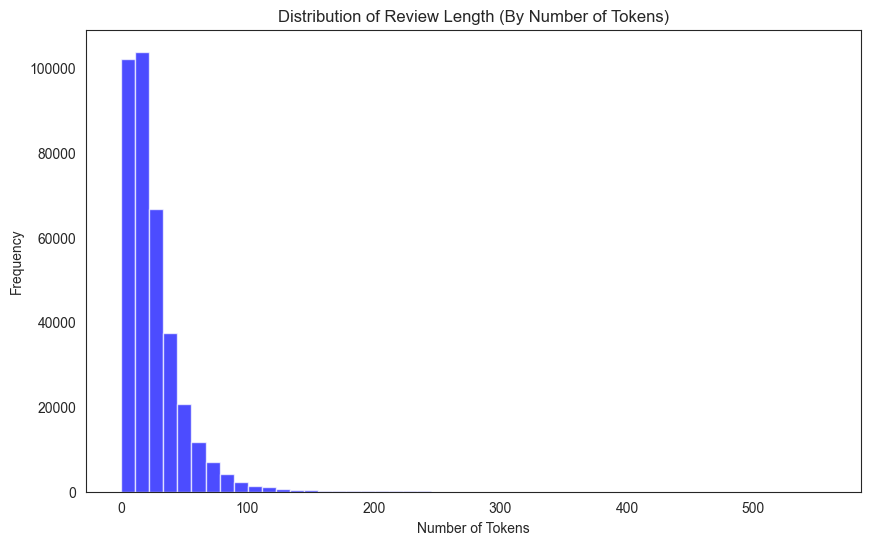

In [110]:
# Plotting the histogram of the distribution of the length of the reviews (by number of tokens)
plt.figure(figsize=(10, 6))  
plt.hist(train_reviews['review_length'], bins=50, color='blue', alpha=0.7) 
plt.title('Distribution of Review Length (By Number of Tokens)')  
plt.xlabel('Number of Tokens')  
plt.ylabel('Frequency')  
plt.grid(False)  
plt.show()

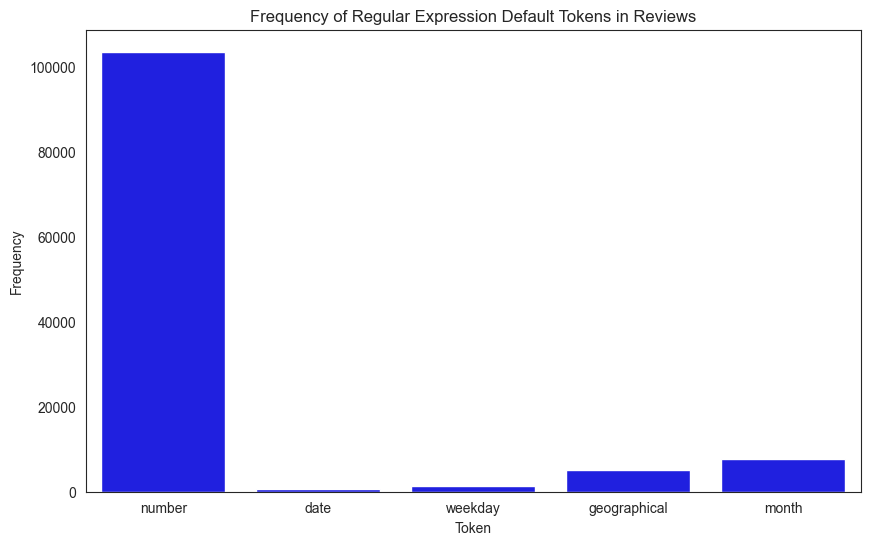

In [111]:
# Create a list of regular expression default tokens to count
tokens_to_count = ['number', 'date', 'weekday', 'geographical', 'month']

# Initialize a dictionary to hold counts
token_counts = {token: 0 for token in tokens_to_count}

# Loop through the column and count occurrences
for tokens in train_reviews['comments_lemmatized']:
    for token in tokens:
        if token in tokens_to_count:
            token_counts[token] += 1

# Convert dictionary to DataFrame for plotting
token_counts_df = pd.DataFrame(list(token_counts.items()), columns=['Token', 'Frequency'])

# Create the countplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Token', y='Frequency', data=token_counts_df, color='blue')
plt.title('Frequency of Regular Expression Default Tokens in Reviews')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.show()

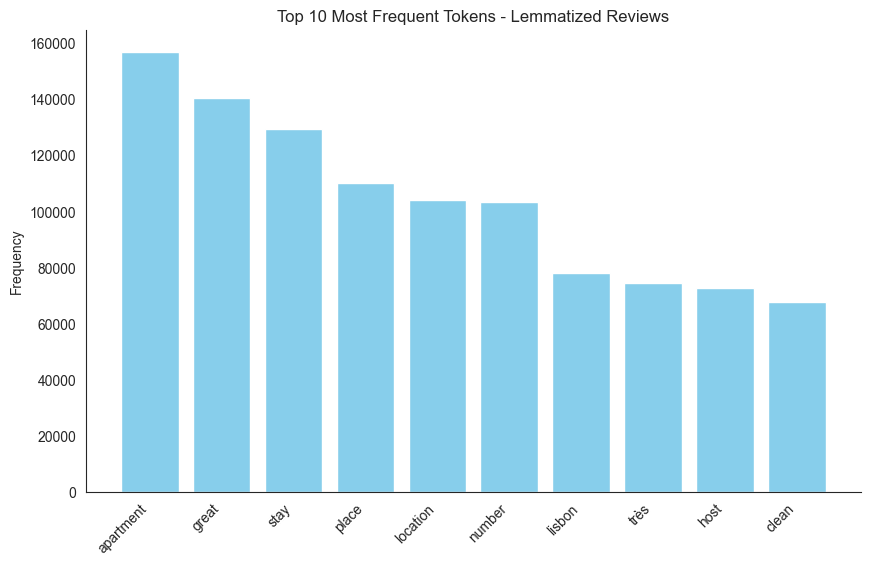

In [112]:
# Flat all the words in the lemmatized comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_lemmatized'] for word in sublist]

freq = pd.Series(all_words).value_counts()

# Get the top 10 most frequent words
top_freq = freq.head(10)

# Extract the labels and values for the plot
x_labels = top_freq.index
values = top_freq.values

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
plt.bar(x_labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens - Lemmatized Reviews')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

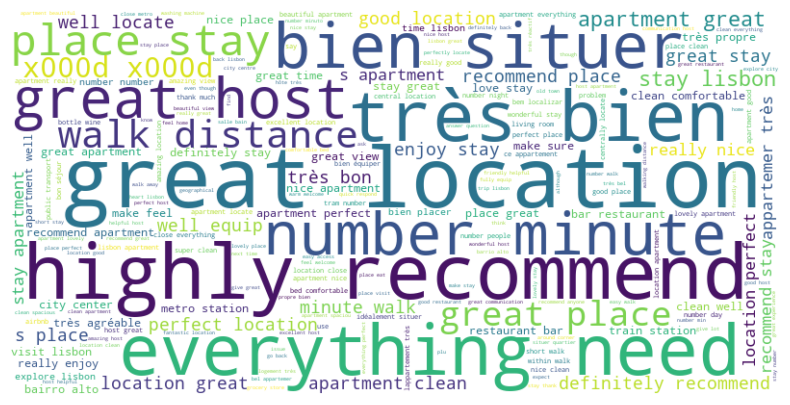

In [113]:
# Flat all the words in the lemmatized comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_lemmatized'] for word in sublist]

# Join all words into a single string
all_reviews = ' '.join(all_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [114]:
# Flat all the words in the lemmatized comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_lemmatized'] for word in sublist]

# Create a series from the list of words to count frequencies
freq = pd.Series(all_words).value_counts()

# Sort the frequencies in ascending order to find the least frequent tokens
freq = freq.sort_values(ascending=True)

# Get the top 10 least frequent tokens
x_labels = freq.index[:10]
values = freq[:10]

values

cleannicely              1
steategicaaffirmation    1
twijfelaars              1
vestiging                1
얘깁니다                     1
같다는                      1
rustrutturato            1
주의해야                     1
언덕이니                     1
Wohlfühlfaktore          1
Name: count, dtype: int64

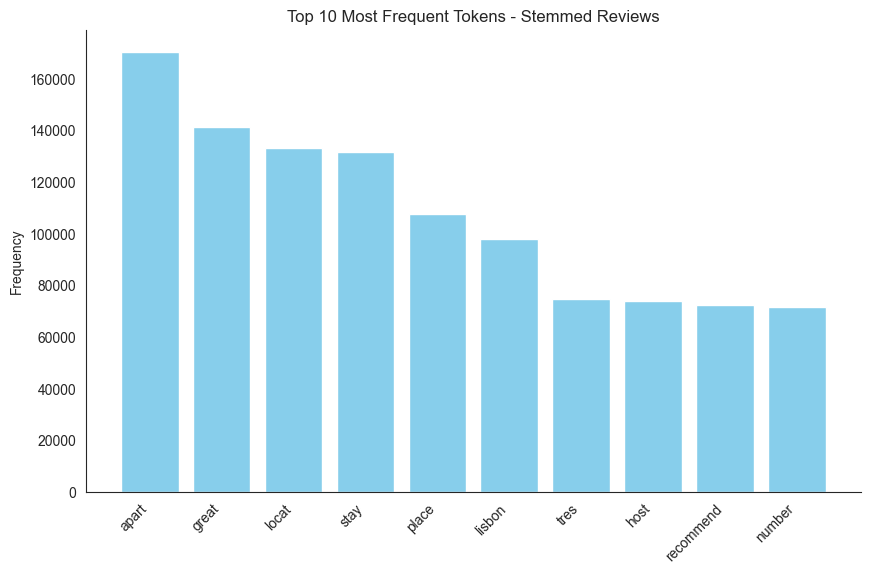

In [115]:
# Flat all the words in the stemmed comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_stemmed'] for word in sublist]

freq = pd.Series(all_words).value_counts()

# Get the top 10 most frequent words
top_freq = freq.head(10)  

# Extract the labels and values for the plot
x_labels = top_freq.index
values = top_freq.values

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
plt.bar(x_labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens - Stemmed Reviews')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

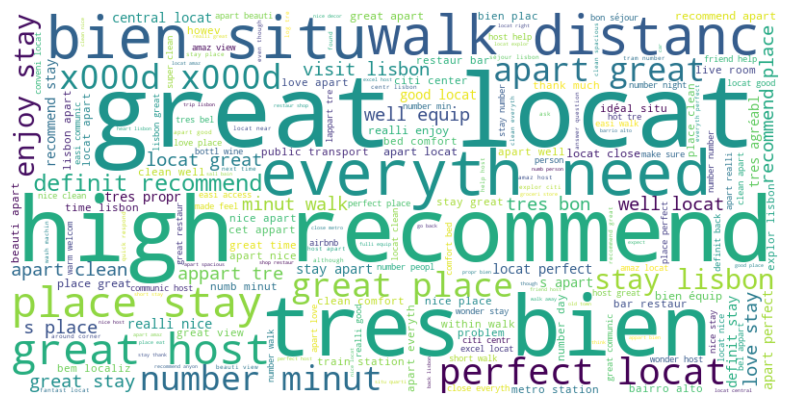

In [116]:
# Flat all the words in the stemmed comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_stemmed'] for word in sublist]

# Join all words into a single string
all_reviews = ' '.join(all_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [117]:
# Flat all the words in the stemmed comments column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train_reviews['comments_stemmed'] for word in sublist]

# Create a series from the list of words to count frequencies
freq = pd.Series(all_words).value_counts()

# Sort the frequencies in ascending order to find the least frequent tokens
freq = freq.sort_values(ascending=True)

# Get the top 10 least frequent tokens
x_labels = freq.index[:10]
values = freq[:10]

values

oír             1
buildingroom    1
multiblock      1
klebrig         1
laaang          1
якоб            1
сдава           1
ausflugstour    1
bucheb          1
wertlegt        1
Name: count, dtype: int64

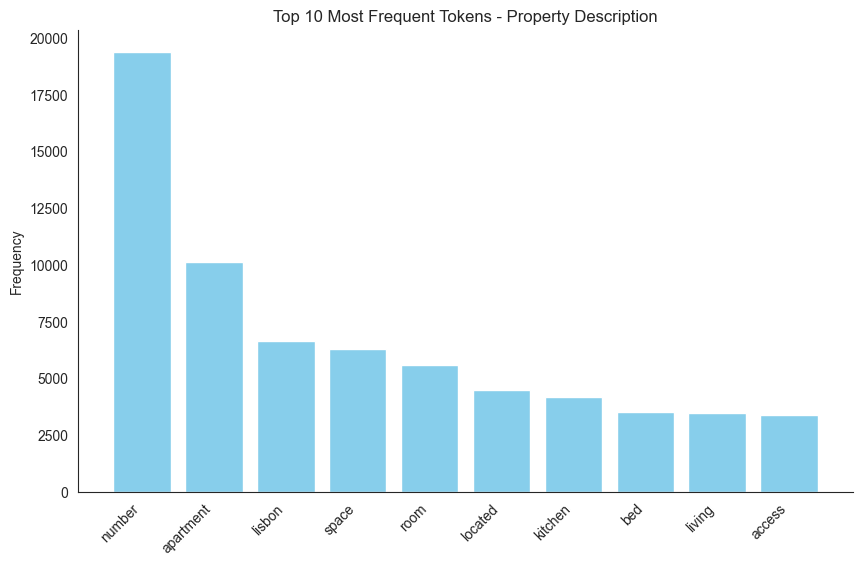

In [118]:
# Flat all the words in the description column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train['description'] for word in sublist]

freq = pd.Series(all_words).value_counts()

# Get the top 10 most frequent words
top_freq = freq.head(10)

# Extract the labels and values for the plot
x_labels = top_freq.index
values = top_freq.values

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
plt.bar(x_labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens - Property Description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

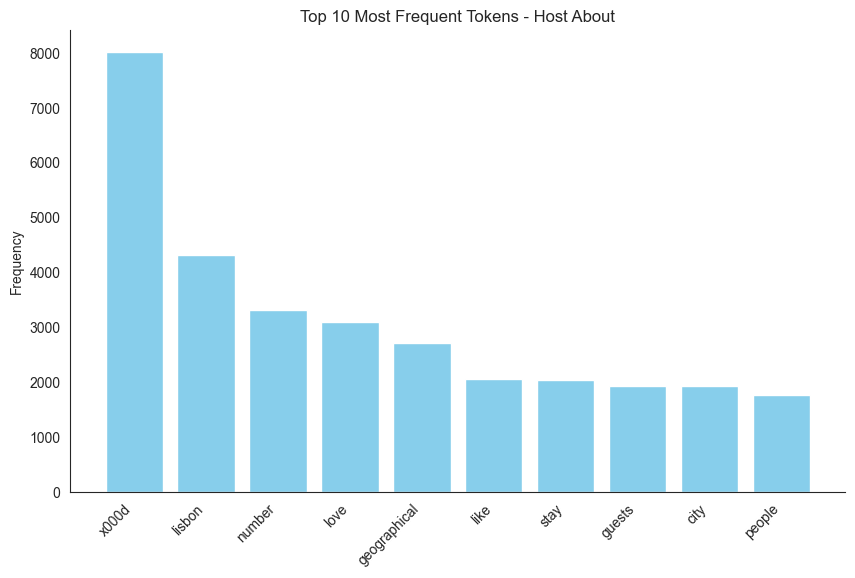

In [119]:
# Flat all the words in the host about column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train['host_about'] for word in sublist]

freq = pd.Series(all_words).value_counts()

# Get the top 10 most frequent words
top_freq = freq.head(10)

# Extract the labels and values for the plot
x_labels = top_freq.index
values = top_freq.values

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
plt.bar(x_labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens - Host About')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

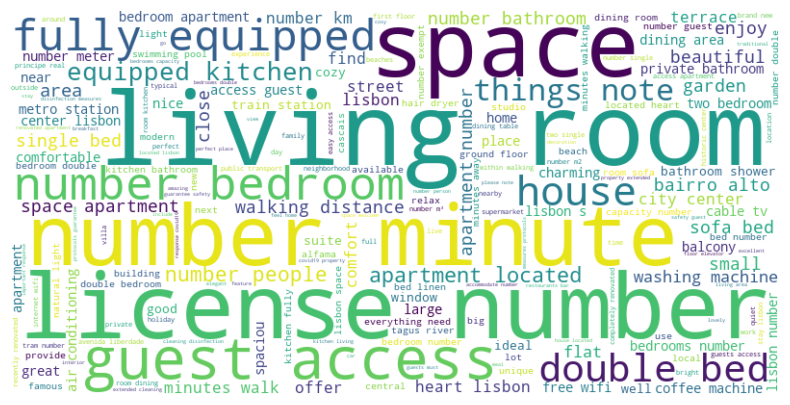

In [120]:
# Flat all the words in the description column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train['description'] for word in sublist]

# Join all words into a single string
all_reviews = ' '.join(all_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

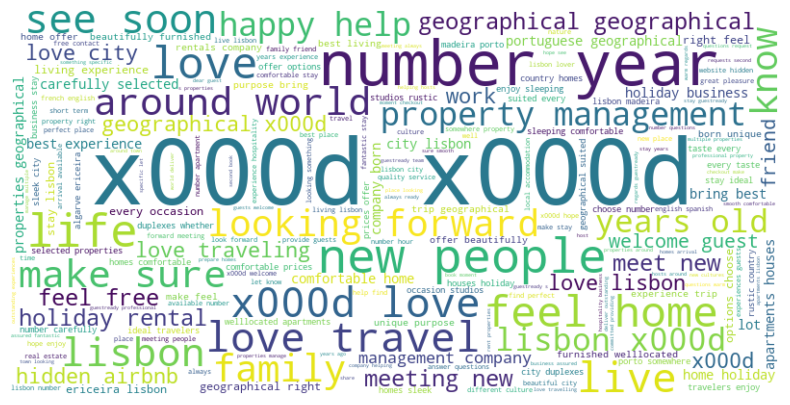

In [121]:
# Flat all the words in the host about column, ensuring they are properly converted from strings to lists
all_words = [word for sublist in train['host_about'] for word in sublist]

# Join all words into a single string
all_reviews = ' '.join(all_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Exporting the train datasets before performing sentiment analysis
train.to_csv('train_before_sentiment_analysis.csv')
train_reviews.to_csv('train_reviews_before_sentiment_analysis.csv')

In [32]:
# Read the saved datasets
train = pd.read_csv('train_before_sentiment_analysis.csv')
train_reviews = pd.read_csv('train_reviews_before_sentiment_analysis.csv')

In [33]:
# Remove an extra unnecessary column
train.drop('Unnamed: 0', axis=1, inplace=True)
train_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [123]:
# Exporting the test datasets before performing sentiment analysis
test.to_csv('test_before_sentiment_analysis.csv')
test_reviews.to_csv('test_reviews_before_sentiment_analysis.csv')

In [34]:
# Read the saved datasets
test = pd.read_csv('test_before_sentiment_analysis.csv')
test_reviews = pd.read_csv('test_reviews_before_sentiment_analysis.csv')

In [35]:
# Remove an extra unnecessary column
test.drop('Unnamed: 0', axis=1, inplace=True)
test_reviews.drop('Unnamed: 0', axis=1, inplace=True)

<a id='Sentiment-Analysis'></a>
### 2.10. EXTRA: Sentiment Analysis on the Reviews 

In [36]:
# Function to convert string representation of list to an actual list and concatenate elements
def concat_elements(list_str):
    list_obj = ast.literal_eval(list_str)
    return ' '.join(list_obj)

In [37]:
# Applying the function to create the new column on the train_reviews dataset
train_reviews['concatenated_comments'] = train_reviews['comments_lemmatized'].apply(concat_elements)

In [38]:
# Display the train_reviews DataFrame with the new column
train_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...
1,1,['good'],cy,['good'],['good'],1,good
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...
3,1,"['hostel', 'neu', 'deshalb', 'funktionierte', ...",de,"['hostel', 'neu', 'deshalb', 'funktionieren', ...","['hostel', 'neu', 'deshalb', 'funktioniert', '...",52,hostel neu deshalb funktionieren tadellos schn...
4,1,"['fine', 'dorm', 'think', 'people', 'staying',...",en,"['fine', 'dorm', 'think', 'people', 'stay', 'f...","['fine', 'dorm', 'think', 'peopl', 'stay', 'fa...",12,fine dorm think people stay far less bathroom ...


In [39]:
# Delete empty reviews
train_reviews = train_reviews[train_reviews['concatenated_comments'] != '']

In [40]:
# Reset the index of 'train_reviews'
train_reviews.reset_index(drop=True, inplace=True)

In [41]:
# Truncate each list in 'concatenated_comments' to the first 60 elements (tokens)
train_reviews['concatenated_comments'] = train_reviews['concatenated_comments'].apply(lambda x: ' '.join(x.split()[:60]))

In [42]:
# Check the maximum length of the reviews on the train_reviews dataset, in terms of characters
max(train_reviews['concatenated_comments'].str.len())

1370

In [43]:
# Filter for only rows where the length of 'concatenated_comments' is less than or equal to 450 characters
train_reviews = train_reviews[train_reviews['concatenated_comments'].str.len() <= 450]

In [44]:
# Confirm that the maximum length of the column is now 450
max(train_reviews['concatenated_comments'].str.len())

450

In [49]:
# Apply the Sentiment Analysis task to the concatenated comments column
text = list(train_reviews['concatenated_comments'])
sentiment = pipeline(model="nlptown/bert-base-multilingual-uncased-sentiment", task='sentiment-analysis')

def sentiments_with_progress(large_batch):
    sentiments = []
    for text in tqdm(large_batch, desc="Tokenizing", unit="text"):
        sentiments.append(sentiment(text))
    return sentiments

results = sentiments_with_progress(text)

# Check the results of the sentiment analysis task
results

Tokenizing: 100%|██████████| 356005/356005 [6:10:22<00:00, 16.02text/s]      


[[{'label': '4 stars', 'score': 0.43575698137283325}],
 [{'label': '4 stars', 'score': 0.49696317315101624}],
 [{'label': '3 stars', 'score': 0.33150041103363037}],
 [{'label': '4 stars', 'score': 0.4264170229434967}],
 [{'label': '4 stars', 'score': 0.4871892035007477}],
 [{'label': '4 stars', 'score': 0.5373793244361877}],
 [{'label': '4 stars', 'score': 0.4719417989253998}],
 [{'label': '4 stars', 'score': 0.4695005714893341}],
 [{'label': '5 stars', 'score': 0.38148418068885803}],
 [{'label': '4 stars', 'score': 0.5849835276603699}],
 [{'label': '5 stars', 'score': 0.528237521648407}],
 [{'label': '4 stars', 'score': 0.45122987031936646}],
 [{'label': '4 stars', 'score': 0.5593996047973633}],
 [{'label': '4 stars', 'score': 0.4368409216403961}],
 [{'label': '4 stars', 'score': 0.46025270223617554}],
 [{'label': '4 stars', 'score': 0.4902671277523041}],
 [{'label': '1 star', 'score': 0.5706629157066345}],
 [{'label': '5 stars', 'score': 0.4042084217071533}],
 [{'label': '3 stars', '

In [50]:
# Function to map star ratings to numerical values
def map_star_rating(label):
    star_mapping = {
        '1 star': 1,
        '2 stars': 2,
        '3 stars': 3,
        '4 stars': 4,
        '5 stars': 5
    }
    return star_mapping.get(label, 0)  # Default to 0 if label is not found

# Add the 'sentiment' from the results to the train_reviews DataFrame as a new column
train_reviews['sentiment'] = [map_star_rating(result[0]['label']) for result in results]

train_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4
1,1,['good'],cy,['good'],['good'],1,good,4
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3
3,1,"['hostel', 'neu', 'deshalb', 'funktionierte', ...",de,"['hostel', 'neu', 'deshalb', 'funktionieren', ...","['hostel', 'neu', 'deshalb', 'funktioniert', '...",52,hostel neu deshalb funktionieren tadellos schn...,4
4,1,"['fine', 'dorm', 'think', 'people', 'staying',...",en,"['fine', 'dorm', 'think', 'people', 'stay', 'f...","['fine', 'dorm', 'think', 'peopl', 'stay', 'fa...",12,fine dorm think people stay far less bathroom ...,4


In [51]:
# Check the distribution of the 'sentiment' feature on the train_reviews dataset
train_reviews['sentiment'].value_counts()

sentiment
5    242695
4     90469
3     14826
1      5407
2      2608
Name: count, dtype: int64

In [52]:
# Export the train_reviews dataset after the sentiment analysis task
train_reviews.to_csv('train_reviews_with_sentiment_analysis.csv')

In [53]:
# Apply the above defined function to convert string representation of list to an actual list and concatenate elements, on the test dataset
test_reviews['concatenated_comments'] = test_reviews['comments_lemmatized'].apply(concat_elements)

In [54]:
# Display the test_reviews dataset with the new column
test_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...
3,1,"['lisbon', 'month', 'number', 'number', 'adult...",en,"['lisbon', 'month', 'number', 'number', 'adult...","['lisbon', 'month', 'number', 'number', 'adult...",25,lisbon month number number adult number child ...
4,1,"['host', 'antonio', 'helpful', 'information', ...",en,"['host', 'antonio', 'helpful', 'information', ...","['host', 'antonio', 'help', 'inform', 'lissabo...",63,host antonio helpful information lissabon pick...


In [55]:
# Delete empty reviews on the test_reviews dataset
test_reviews = test_reviews[test_reviews['concatenated_comments'] != '']

In [56]:
# Reset the index of 'test_reviews'
test_reviews.reset_index(drop=True, inplace=True)

In [57]:
# Truncate each list in 'concatenated_comments' to the first 60 elements (tokens)
test_reviews['concatenated_comments'] = test_reviews['concatenated_comments'].apply(lambda x: ' '.join(x.split()[:60]))

In [58]:
# Check the maximum length of the reviews on the test_reviews dataset, in terms of characters
max(test_reviews['concatenated_comments'].str.len())

723

In [59]:
# Filter for only rows where the length of 'concatenated_comments' is less than or equal to 450 characters
test_reviews = test_reviews[test_reviews['concatenated_comments'].str.len() <= 450]

In [60]:
max(test_reviews['concatenated_comments'].str.len())

450

In [61]:
text_test_reviews = list(test_reviews['concatenated_comments'])

# Apply the sentiment analysis task on the test_reviews dataset
results_test_reviews = sentiments_with_progress(text_test_reviews)

# Check the results of the sentiment analysis task
results_test_reviews

Tokenizing: 100%|██████████| 41267/41267 [26:23<00:00, 26.05text/s]


[[{'label': '5 stars', 'score': 0.9035666584968567}],
 [{'label': '4 stars', 'score': 0.663542628288269}],
 [{'label': '4 stars', 'score': 0.3906041979789734}],
 [{'label': '4 stars', 'score': 0.4824673533439636}],
 [{'label': '4 stars', 'score': 0.5846157670021057}],
 [{'label': '4 stars', 'score': 0.4820447266101837}],
 [{'label': '5 stars', 'score': 0.7814397215843201}],
 [{'label': '4 stars', 'score': 0.46572861075401306}],
 [{'label': '5 stars', 'score': 0.7602552771568298}],
 [{'label': '5 stars', 'score': 0.5470815896987915}],
 [{'label': '5 stars', 'score': 0.4779209494590759}],
 [{'label': '4 stars', 'score': 0.4969393312931061}],
 [{'label': '1 star', 'score': 0.35446178913116455}],
 [{'label': '5 stars', 'score': 0.6273751258850098}],
 [{'label': '2 stars', 'score': 0.4660125970840454}],
 [{'label': '5 stars', 'score': 0.4957999587059021}],
 [{'label': '5 stars', 'score': 0.6648529767990112}],
 [{'label': '4 stars', 'score': 0.3490799367427826}],
 [{'label': '5 stars', 'scor

In [62]:
# Add the 'sentiment' from the results to the DataFrame as a new column, in the test_reviews dataset
test_reviews['sentiment'] = [map_star_rating(result[0]['label']) for result in results_test_reviews]

test_reviews.head()

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...,5
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...,4
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...,4
3,1,"['lisbon', 'month', 'number', 'number', 'adult...",en,"['lisbon', 'month', 'number', 'number', 'adult...","['lisbon', 'month', 'number', 'number', 'adult...",25,lisbon month number number adult number child ...,4
4,1,"['host', 'antonio', 'helpful', 'information', ...",en,"['host', 'antonio', 'helpful', 'information', ...","['host', 'antonio', 'help', 'inform', 'lissabo...",63,host antonio helpful information lissabon pick...,4


In [63]:
# Check the distribution of the 'sentiment' feature on the test_reviews dataset
test_reviews['sentiment'].value_counts()

sentiment
5    28504
4    10183
3     1613
1      632
2      335
Name: count, dtype: int64

In [64]:
# Export the test_reviews dataset after the sentiment analysis task
test_reviews.to_csv('test_reviews_with_sentiment_analysis.csv')

<a id='Train-Validation-Split'></a>
### 2.11. Train/Validation Split

In [73]:
# Read the current train_reviews and test_reviews datasets (after performing the sentiment analysis) so that they are stored in memory for future
# uses
train_reviews = pd.read_csv('train_reviews_with_sentiment_analysis.csv')
test_reviews = pd.read_csv('test_reviews_with_sentiment_analysis.csv')

# Drop unnecessary created columns, created upon reading
train_reviews.drop('Unnamed: 0', axis=1, inplace=True)
test_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [74]:
# Drop the columns 'unlisted' and 'property_id' from the 'train' DataFrame to create the features dataset
# The 'axis=1' parameter indicates that we are dropping columns, not rows
features = train.drop(['unlisted', 'property_id'], axis=1)

# Extract the 'unlisted' column from the 'train' DataFrame to create the target dataset
target = train['unlisted']

In [75]:
# Perform the train/validation split, stratifying on 'unlisted' target
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Display the resulting DataFrames' shape
print("Train DataFrame:")
print(X_train.shape)
print("\nValidation DataFrame:")
print(X_val.shape)

Train DataFrame:
(4998, 6)

Validation DataFrame:
(1250, 6)


In [76]:
# Check if the original 'unlisted' distribution is being preserved
y_train.value_counts(normalize=True)

unlisted
0    0.726691
1    0.273309
Name: proportion, dtype: float64

In [77]:
# Check if the original 'unlisted' distribution is being preserved
y_val.value_counts(normalize=True)

unlisted
0    0.7264
1    0.2736
Name: proportion, dtype: float64

In [78]:
# Create the X_test dataset
X_test = test

# Drop the property_id column on the X_test to remain only with training features
X_test.drop('property_id', inplace=True, axis=1)

In [80]:
# Checking the shape of the X_test dataset
X_test.shape

(695, 6)

In [81]:
# Export the resulting datasets to avoid having to run everything from the beginning
X_train = X_train.to_csv('X_train.csv')
X_val = X_val.to_csv('X_val.csv')
y_train = y_train.to_csv('y_train.csv')
y_val = y_val.to_csv('y_val.csv')
X_test = X_test.to_csv('X_test.csv')

In [18]:
# Read the saved datasets
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
X_test = pd.read_csv('X_test.csv')

In [19]:
# Remove an extra unnecessary column, created upon reading the datasets
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_val.drop('Unnamed: 0', axis=1, inplace=True)
y_train.drop('Unnamed: 0', axis=1, inplace=True)
y_val.drop('Unnamed: 0', axis=1, inplace=True)
X_test.drop('Unnamed: 0', axis=1, inplace=True)

<a id='Feature-Engineering'></a>
# 3. Feature Engineering

<a id='TF-IDF-LEMMATIZED'></a>
### 3.1. TF-IDF for Property Description and Host About using Lemmatization

In [20]:
# Special join function to handle lists of tokens
def special_join(x):
    if isinstance(x, str):
        return x
    else:
        return ' '.join(x)

# Combine the 'description' and 'host_about' columns into single texts
X_train['combined_text_lemmatized'] = X_train['description_lemmatized'].apply(special_join) + " " + X_train['host_about_lemmatized'].apply(special_join)
X_val['combined_text_lemmatized'] = X_val['description_lemmatized'].apply(special_join) + " " + X_val['host_about_lemmatized'].apply(special_join)
X_test['combined_text_lemmatized'] = X_test['description_lemmatized'].apply(special_join) + " " + X_test['host_about_lemmatized'].apply(special_join)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer_lemmatized = TfidfVectorizer(lowercase=False, stop_words=None)

# Fit the vectorizer on the training data and transform the training data
tfidf_matrix_train_lemmatized = tfidf_vectorizer_lemmatized.fit_transform(X_train['combined_text_lemmatized'])

# Transform the validation and test data
tfidf_matrix_val_lemmatized = tfidf_vectorizer_lemmatized.transform(X_val['combined_text_lemmatized'])
tfidf_matrix_test_lemmatized = tfidf_vectorizer_lemmatized.transform(X_test['combined_text_lemmatized'])

# Convert the target variables to numpy arrays
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

# Print the shapes to verify
print("TF-IDF matrix for training data:", tfidf_matrix_train_lemmatized.shape)
print("TF-IDF matrix for validation data:", tfidf_matrix_val_lemmatized.shape)
print("TF-IDF matrix for test data:", tfidf_matrix_test_lemmatized.shape)

TF-IDF matrix for training data: (4998, 17710)
TF-IDF matrix for validation data: (1250, 17710)
TF-IDF matrix for test data: (695, 17710)


In [21]:
# Convert the first document's TF-IDF feature matrix to a dense format (from sparse format)
# and create a DataFrame with the feature names as the index and "TF-IDF" as the column name
tfidf_train_lemmatized = pd.DataFrame(tfidf_matrix_train_lemmatized[0].T.todense(), index=tfidf_vectorizer_lemmatized.get_feature_names_out(), columns=["TF-IDF"])

# Sort the DataFrame by the "TF-IDF" column in descending order to see the most important features
tfidf_train_lemmatized = tfidf_train_lemmatized.sort_values('TF-IDF', ascending=False)

# Print the top 25 features (words) with the highest TF-IDF scores
tfidf_train_lemmatized.head(25)

,TF-IDF
81493al,0.258236
stationbuse,0.258236
fund,0.245358
fátima,0.232480
gulbenkian,0.214206
conversation,0.195318
metro,0.186169
court,0.183555
vii,0.179982
eduardo,0.177388


<a id='TF-IDF-STEMMED'></a>
### 3.2. TF-IDF for Property Description and Host About using Stemming

In [22]:
# Special join function to handle lists of tokens
def special_join(x):
    if isinstance(x, str):
        return x
    else:
        return ' '.join(x)

# Combine the 'description' and 'host_about' columns into single texts
X_train['combined_text_stemmed'] = X_train['description_stemmed'].apply(special_join) + " " + X_train['host_about_stemmed'].apply(special_join)
X_val['combined_text_stemmed'] = X_val['description_stemmed'].apply(special_join) + " " + X_val['host_about_stemmed'].apply(special_join)
X_test['combined_text_stemmed'] = X_test['description_stemmed'].apply(special_join) + " " + X_test['host_about_stemmed'].apply(special_join)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer_stemmed = TfidfVectorizer(lowercase=False, stop_words=None)

# Fit the vectorizer on the training data and transform the training data
tfidf_matrix_train_stemmed = tfidf_vectorizer_stemmed.fit_transform(X_train['combined_text_stemmed'])

# Transform the validation and test data
tfidf_matrix_val_stemmed = tfidf_vectorizer_stemmed.transform(X_val['combined_text_stemmed'])
tfidf_matrix_test_stemmed = tfidf_vectorizer_stemmed.transform(X_test['combined_text_stemmed'])

# Print the shapes to verify
print("TF-IDF matrix for training data:", tfidf_matrix_train_stemmed.shape)
print("TF-IDF matrix for validation data:", tfidf_matrix_val_stemmed.shape)
print("TF-IDF matrix for test data:", tfidf_matrix_test_stemmed.shape)

TF-IDF matrix for training data: (4998, 15697)
TF-IDF matrix for validation data: (1250, 15697)
TF-IDF matrix for test data: (695, 15697)


In [23]:
# Convert the first document's TF-IDF feature matrix to a dense format (from sparse format)
# and create a DataFrame with the feature names as the index and "TF-IDF" as the column name
tfidf_train_stemmed = pd.DataFrame(tfidf_matrix_train_stemmed[0].T.todense(), index=tfidf_vectorizer_stemmed.get_feature_names_out(), columns=["TF-IDF"])

# Sort the DataFrame by the "TF-IDF" column in descending order to see the most important features
tfidf_train_stemmed = tfidf_train_stemmed.sort_values('TF-IDF', ascending=False)

# Print the top 25 features (words) with the highest TF-IDF scores
tfidf_train_stemmed.head(25)

,TF-IDF
stationbus,0.259087
81493al,0.259087
fund,0.246167
fátima,0.233246
gulbenkian,0.214912
convers,0.191844
metro,0.186783
court,0.184160
good,0.179404
vii,0.176152


<a id='GloVe-Embeddings'></a>
### 3.3. GloVe Embeddings for Property Description and Host About

In [24]:
# Remembering how the train_reviews dataset looks like
X_train.head(3)

,description,host_about,description_lemmatized,host_about_lemmatized,description_stemmed,host_about_stemmed,combined_text_lemmatized,combined_text_stemmed
0,"['stay', 'privileged', 'location', 'cozy', 'ch...","['life', 'lived', 'good', 'friends', 'good', '...","['stay', 'privileged', 'location', 'cozy', 'ch...","['life', 'live', 'good', 'friend', 'good', 'fo...","['stay', 'privileg', 'locat', 'cozi', 'charm',...","['life', 'live', 'good', 'friend', 'good', 'fo...","['stay', 'privileged', 'location', 'cozy', 'ch...","['stay', 'privileg', 'locat', 'cozi', 'charm',..."
1,"['spacious', 'apartment', 'number', 'sqm2300sq...","['architect', 'living', 'abroad', 'renting', '...","['spacious', 'apartment', 'number', 'sqm2300sq...","['architect', 'live', 'abroad', 'rent', 'city'...","['spacious', 'apart', 'number', 'sqm2300sqft',...","['architect', 'live', 'abroad', 'rent', 'citi'...","['spacious', 'apartment', 'number', 'sqm2300sq...","['spacious', 'apart', 'number', 'sqm2300sqft',..."
2,"['would', 'like', 'based', 'prime', 'central',...","['filipe', 'manuel', 'x000d', 'x000d', 'airbnb...","['would', 'like', 'base', 'prime', 'central', ...","['filipe', 'manuel', 'x000d', 'x000d', 'airbnb...","['would', 'like', 'base', 'prime', 'central', ...","['filip', 'manuel', 'x000d', 'x000d', 'airbnb'...","['would', 'like', 'base', 'prime', 'central', ...","['would', 'like', 'base', 'prime', 'central', ..."


In [25]:
# Set an embedding dimension of 300
DIM = 300

# Load GloVe model with 840B tokens and specified dimension
glove = vocab.GloVe(name='840B', dim=DIM)
print('Loaded {} words'.format(len(glove.itos)))

# Convert string representations of lists to actual lists for 'description' and 'host_about' in training data
X_train['description_lemmatized'] = X_train['description_lemmatized'].apply(ast.literal_eval)
X_train['host_about_lemmatized'] = X_train['host_about_lemmatized'].apply(ast.literal_eval)

# Convert columns to lists
X_train['description_lemmatized'] = X_train['description_lemmatized'].tolist()
X_train['host_about_lemmatized'] = X_train['host_about_lemmatized'].tolist()

# Convert string representations of lists to actual lists for 'description' and 'host_about' in validation data
X_val['description_lemmatized'] = X_val['description_lemmatized'].apply(ast.literal_eval)
X_val['host_about_lemmatized'] = X_val['host_about_lemmatized'].apply(ast.literal_eval)

# Convert columns to lists
X_val['description_lemmatized'] = X_val['description_lemmatized'].tolist()
X_val['host_about_lemmatized'] = X_val['host_about_lemmatized'].tolist()

# Convert string representations of lists to actual lists for 'description' and 'host_about' in the test data
X_test['description_lemmatized'] = X_test['description_lemmatized'].apply(ast.literal_eval)
X_test['host_about_lemmatized'] = X_test['host_about_lemmatized'].apply(ast.literal_eval)

# Convert columns to lists
X_test['description_lemmatized'] = X_test['description_lemmatized'].tolist()
X_test['host_about_lemmatized'] = X_test['host_about_lemmatized'].tolist()

# Function to get the GloVe vector for a token
def get_glove_vector(word):
    if word in glove.stoi:
        return glove.vectors[glove.stoi[word]].numpy()
    else:
        return np.zeros(DIM)

# Function to create a document matrix using GloVe vectors for each token in the document
def document_matrix_glove(doc):
    return np.array([get_glove_vector(word) for word in doc])

# Apply the document matrix function to 'description' and 'host_about' columns in the training data
X_train['description_lemmatized'] = X_train.apply(lambda row: document_matrix_glove(row['description_lemmatized']), axis=1)
X_train['host_about_lemmatized'] = X_train.apply(lambda row: document_matrix_glove(row['host_about_lemmatized']), axis=1)

# Apply the document matrix function to 'description' and 'host_about' columns in the validation data
X_val['description_lemmatized'] = X_val.apply(lambda row: document_matrix_glove(row['description_lemmatized']), axis=1)
X_val['host_about_lemmatized'] = X_val.apply(lambda row: document_matrix_glove(row['host_about_lemmatized']), axis=1)

# Apply the document matrix function to 'description' and 'host_about' columns in the test data
X_test['description_lemmatized'] = X_test.apply(lambda row: document_matrix_glove(row['description_lemmatized']), axis=1)
X_test['host_about_lemmatized'] = X_test.apply(lambda row: document_matrix_glove(row['host_about_lemmatized']), axis=1)

Loaded 2196017 words


In [26]:
# Check the success of the operations in the train dataset
X_train.head(3)

,description,host_about,description_lemmatized,host_about_lemmatized,description_stemmed,host_about_stemmed,combined_text_lemmatized,combined_text_stemmed
0,"['stay', 'privileged', 'location', 'cozy', 'ch...","['life', 'lived', 'good', 'friends', 'good', '...","[[0.3003300130367279, 0.19993999600410461, -0....","[[0.09359, 0.50877, 0.011249, -0.074822, -0.21...","['stay', 'privileg', 'locat', 'cozi', 'charm',...","['life', 'live', 'good', 'friend', 'good', 'fo...","['stay', 'privileged', 'location', 'cozy', 'ch...","['stay', 'privileg', 'locat', 'cozi', 'charm',..."
1,"['spacious', 'apartment', 'number', 'sqm2300sq...","['architect', 'living', 'abroad', 'renting', '...","[[1.4621000289916992, 0.30208998918533325, 0.1...","[[0.43056, -0.25697, 0.072521, -0.34186, -0.06...","['spacious', 'apart', 'number', 'sqm2300sqft',...","['architect', 'live', 'abroad', 'rent', 'citi'...","['spacious', 'apartment', 'number', 'sqm2300sq...","['spacious', 'apart', 'number', 'sqm2300sqft',..."
2,"['would', 'like', 'based', 'prime', 'central',...","['filipe', 'manuel', 'x000d', 'x000d', 'airbnb...","[[-0.04929099977016449, 0.20483000576496124, -...","[[-0.03558500111103058, -0.6353499889373779, 0...","['would', 'like', 'base', 'prime', 'central', ...","['filip', 'manuel', 'x000d', 'x000d', 'airbnb'...","['would', 'like', 'base', 'prime', 'central', ...","['would', 'like', 'base', 'prime', 'central', ..."


In [27]:
# Check the success of the operations in the validation dataset
X_val.head(3)

,description,host_about,description_lemmatized,host_about_lemmatized,description_stemmed,host_about_stemmed,combined_text_lemmatized,combined_text_stemmed
0,"['confortable', 'apartment', 'anjos', 'charmin...","['hydraulic', 'engineer', 'born', 'raised', 'l...","[[0.5560399889945984, -0.3003099858760834, -0....","[[0.31829, 0.5203, 0.46062, -0.72614, -0.05929...","['confort', 'apart', 'anjo', 'charm', 'spaciou...","['hydraul', 'engin', 'born', 'rais', 'lisbon',...","['confortable', 'apartment', 'anjos', 'charm',...","['confort', 'apart', 'anjo', 'charm', 'spaciou..."
1,"['bairro', 'house', 'charming', 'apartments', ...","['richard', 'partner', 'bairro', 'house', 'ent...","[[0.65388, -0.57094, -0.35072, 0.31556, 0.3660...","[[-0.40791, 0.25417, 0.19281, -0.032151, 0.189...","['bairro', 'hous', 'charm', 'apart', 'room', '...","['richard', 'partner', 'bairro', 'hous', 'enti...","['bairro', 'house', 'charming', 'apartment', '...","['bairro', 'hous', 'charm', 'apart', 'room', '..."
2,"['you', 'will', 'never', 'forget', 'unique', '...","['experience', 'navigation', 'professionally',...","[[-0.11076, 0.30786, -0.5198, 0.035138, 0.1036...","[[0.3423, 0.13529, 0.15073, -0.24977, 0.60504,...","['you', 'will', 'never', 'forget', 'uniqu', 'r...","['experi', 'navig', 'profession', 'leisur', 'c...","['you', 'will', 'never', 'forget', 'unique', '...","['you', 'will', 'never', 'forget', 'uniqu', 'r..."


In [28]:
# Check the success of the operations in the test dataset
X_test.head(3)

,description,host_about,description_lemmatized,host_about_lemmatized,description_stemmed,host_about_stemmed,combined_text_lemmatized,combined_text_stemmed
0,"['space', 'apartment', 'located', 'historic', ...","['I', 'like', 'traveling', 'meeting', 'people'...","[[0.7172499895095825, -0.11524000018835068, 0....","[[0.1941, 0.22603, -0.43764, -0.11387, -0.0727...","['space', 'apart', 'locat', 'histor', 'center'...","['i', 'like', 'travel', 'meet', 'peopl', 'i', ...","['space', 'apartment', 'locate', 'historic', '...","['space', 'apart', 'locat', 'histor', 'center'..."
1,"['important', 'response', 'covid19', 'property...","['home', 'team', 'count', 'every', 'single', '...","[[-0.04518900066614151, 0.23364999890327454, -...","[[0.13523, 0.44992, -0.25227, 0.048482, 0.2736...","['import', 'respons', 'covid19', 'properti', '...","['home', 'team', 'count', 'everi', 'singl', 'd...","['important', 'response', 'covid19', 'property...","['import', 'respons', 'covid19', 'properti', '..."
2,"['bright', 'beautiful', 'spacious', 'fourbedro...","['guestready', 'professional', 'property', 'ma...","[[0.3600200116634369, 0.18068000674247742, -0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","['bright', 'beauti', 'spacious', 'fourbedroom'...","['guestreadi', 'profession', 'properti', 'mana...","['bright', 'beautiful', 'spacious', 'fourbedro...","['bright', 'beauti', 'spacious', 'fourbedroom'..."


In [29]:
# Drop the unnecessary 'combined_text' columns in all datasets
X_train.drop(['combined_text_lemmatized', 'combined_text_stemmed'], axis=1, inplace=True)
X_val.drop(['combined_text_lemmatized', 'combined_text_stemmed'], axis=1, inplace=True)
X_test.drop(['combined_text_lemmatized', 'combined_text_stemmed'], axis=1, inplace=True)

<a id='BERT-BASE-MULTI-UNCASED'></a>
### 3.4. EXTRA: Sentence Embeddings on the Reviews using BERT BASE Multilingual Transformer (Uncased)

In [102]:
# A reminder of what the train_reviews dataset looks like
train_reviews.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4
1,1,['good'],cy,['good'],['good'],1,good,4
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3


In [103]:
# Check the number of records of the train_reviews dataset
len(train_reviews)

356005

In [104]:
# Check the type of each entry in 'concatenated_comments' and filter out non-string entries, in the train_reviews dataset
train_reviews = train_reviews[train_reviews['concatenated_comments'].apply(lambda x: isinstance(x, str))]

In [105]:
# Recheck the number of records of the train_reviews dataset
len(train_reviews)

356004

In [106]:
# Load pre-trained BERT Multilingual Uncased tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertModel.from_pretrained("bert-base-multilingual-uncased")

# Convert the 'concatenated_comments' (in the train_reviews dataset) column to a list of texts
text = list(train_reviews['concatenated_comments'])

# Function to get sentence embeddings with progress bar
def sentence_embeddings_with_progress(large_batch):
    
    # Initialize list to store averaged embeddings
    averaged_embeddings = []

    # Loop through each text with progress bar
    for text in tqdm(large_batch, desc="Tokenizing", unit="text"):
        
        # Tokenize the text and convert to tensors
        encoded_input = tokenizer(text, return_tensors='pt', padding=True, max_length=512)
        
        # Get model output
        with torch.no_grad():  # Disable gradient calculation for inference
            model_output = model(**encoded_input)
        
        # Compute the average of the last hidden state
        avg_embedding = torch.mean(model_output.last_hidden_state.squeeze(0), dim=0)
        
        # Convert to numpy array for easier handling in DataFrame
        avg_embedding_np = avg_embedding.cpu().numpy()
        
        # Append the averaged embedding to the list
        averaged_embeddings.append(avg_embedding_np)

    return averaged_embeddings

# Get sentence embeddings for the list of texts
outputs_train = sentence_embeddings_with_progress(text)

Tokenizing:   0%|          | 0/356004 [00:00<?, ?text/s]C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\transformers\tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Tokenizing: 100%|██████████| 356004/356004 [5:03:09<00:00, 19.57text/s]      


In [107]:
# Add the sentence embeddings to the train_reviews DataFrame
train_reviews['sentence_embeddings'] = outputs_train

In [108]:
# Export the train_reviews dataset after the BERT Multilingual Sentence Embeddings
train_reviews.to_csv('train_reviews_with_sentence_embeddings_bert_multilingual.csv')

In [30]:
# Read the saved dataset
train_reviews = pd.read_csv('train_reviews_with_sentence_embeddings_bert_multilingual.csv')
train_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [31]:
# Check how the train_reviews dataset looks like, after applying the BERT Multilingual Sentence Embeddings
train_reviews.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4,[-1.67620286e-01 1.27289398e-02 1.82780266e-...
1,1,['good'],cy,['good'],['good'],1,good,4,[-7.90571347e-02 3.34066540e-01 -7.97690228e-...
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3,[-2.47390106e-01 -9.89657938e-02 2.47941568e-...


In [111]:
# Check the number of records of the test_reviews dataset
len(test_reviews)

41267

In [112]:
# Check the type of each entry in 'concatenated_comments' and filter out non-string entries, in the test_reviews dataset
test_reviews = test_reviews[test_reviews['concatenated_comments'].apply(lambda x: isinstance(x, str))]

In [113]:
# Recheck the number of records in the test_reviews dataset
len(test_reviews)

41267

In [114]:
# Convert the 'concatenated_comments' (in the test_reviews dataset) column to a list of texts
text_test_reviews = list(test_reviews['concatenated_comments'])

In [115]:
# Get the sentence embeddings for the list of texts
outputs_test = sentence_embeddings_with_progress(text_test_reviews)

Tokenizing:   0%|          | 0/41267 [00:00<?, ?text/s]C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\transformers\tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Tokenizing: 100%|██████████| 41267/41267 [25:35<00:00, 26.88text/s]


In [116]:
# Add the sentence embeddings to the test_reviews DataFrame
test_reviews['sentence_embeddings'] = outputs_test

In [117]:
# Export the test_reviews dataset after the BERT Multilingual Sentence Embeddings
test_reviews.to_csv('test_reviews_with_sentence_embeddings_bert_multilingual.csv')

In [165]:
# Read the saved dataset
test_reviews = pd.read_csv('test_reviews_with_sentence_embeddings_bert_multilingual.csv')
test_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [166]:
# Check how the test_reviews dataset looks like, after applying the BERT Multilingual Sentence Embeddings
test_reviews.head(10)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...,5,[-1.97801366e-01 -7.03575164e-02 3.61720532e-...
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...,4,[-1.21244431e-01 -1.35422006e-01 2.59434998e-...
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...,4,[-3.06668073e-01 -2.20760062e-01 2.81669110e-...
3,1,"['lisbon', 'month', 'number', 'number', 'adult...",en,"['lisbon', 'month', 'number', 'number', 'adult...","['lisbon', 'month', 'number', 'number', 'adult...",25,lisbon month number number adult number child ...,4,[-8.51777568e-02 -2.54057556e-01 4.36906219e-...
4,1,"['host', 'antonio', 'helpful', 'information', ...",en,"['host', 'antonio', 'helpful', 'information', ...","['host', 'antonio', 'help', 'inform', 'lissabo...",63,host antonio helpful information lissabon pick...,4,[-0.19571084 -0.22247857 0.1740892 0.095998...
5,1,"['nice', 'place', 'large', 'clean', 'apartment...",en,"['nice', 'place', 'large', 'clean', 'apartment...","['nice', 'place', 'larg', 'clean', 'apart', 'x...",14,nice place large clean apartment x000d everthi...,4,[-3.15689087e-01 -2.94187456e-01 2.87624717e-...
6,1,"['everything', 'great', 'antonio', 'mother', '...",en,"['everything', 'great', 'antonio', 'mother', '...","['everyth', 'great', 'antonio', 'mother', 'mar...",14,everything great antonio mother margarida good...,5,[-1.29432872e-01 -3.80397290e-02 1.19520761e-...
7,1,"['comfortable', 'clean', 'nice', 'flat', 'plea...",en,"['comfortable', 'clean', 'nice', 'flat', 'plea...","['comfort', 'clean', 'nice', 'flat', 'pleasant...",16,comfortable clean nice flat pleasant sunny ter...,4,[-1.41964495e-01 1.91007346e-01 1.28499195e-...
8,1,"['séjour', 'idéal', 'accueillis', 'très', 'cha...",fr,"['séjour', 'idéal', 'accueillir', 'très', 'cha...","['séjour', 'idéal', 'accueil', 'tres', 'chaleu...",35,séjour idéal accueillir très chaleureusement l...,5,[-1.20031498e-01 -1.66678026e-01 2.14649141e-...
9,1,"['spent', 'great', 'time', 'place']",en,"['spend', 'great', 'time', 'place']","['spent', 'great', 'time', 'place']",4,spend great time place,5,[-6.75390139e-02 2.16438711e-01 4.27734554e-...


<a id='XLM-ROBERTA-BASE'></a>
### 3.5. EXTRA: Sentence Embeddings on the Reviews, using XLM-RoBERTa Multilingual Transformer

In [120]:
# Load pre-trained XLM-RoBERTa tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained("xlm-roberta-base")

# Convert the 'concatenated_comments' (in the train_reviews dataset) column to a list of texts
text = list(train_reviews['concatenated_comments'])

# Function to get sentence embeddings with progress bar
def sentence_embeddings_with_progress(large_batch):
    
    # Initialize list to store averaged embeddings
    averaged_embeddings = []

    # Loop through each text with progress bar
    for text in tqdm(large_batch, desc="Tokenizing", unit="text"):
        
        # Tokenize the text and convert to tensors
        encoded_input = tokenizer(text, return_tensors='pt', padding=True, max_length=512)
        
        # Get model output
        with torch.no_grad():  # Disable gradient calculation for inference
            model_output = model(**encoded_input)
        
        # Compute the average of the last hidden state
        avg_embedding = torch.mean(model_output.last_hidden_state.squeeze(0), dim=0)
        
        # Convert to numpy array for easier handling in DataFrame
        avg_embedding_np = avg_embedding.cpu().numpy()
        
        # Append the averaged embedding to the list
        averaged_embeddings.append(avg_embedding_np)

    return averaged_embeddings

# Get sentence embeddings for the list of texts
outputs_train = sentence_embeddings_with_progress(text)

Tokenizing:   0%|          | 0/356004 [00:00<?, ?text/s]C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\transformers\tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Tokenizing: 100%|██████████| 356004/356004 [3:48:19<00:00, 25.99text/s]  


In [121]:
# Add the sentence embeddings to the train_reviews DataFrame
train_reviews['sentence_embeddings'] = outputs_train

In [122]:
# Export the train_reviews dataset after applying the XLM-RoBERTa Multilingual Sentence Embeddings
train_reviews.to_csv('train_reviews_with_sentence_embeddings_xlm_roberta.csv')

In [123]:
# Read the saved dataset
train_reviews = pd.read_csv('train_reviews_with_sentence_embeddings_xlm_roberta.csv')
train_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [124]:
# Check how the train_reviews dataset looks like, after applying the XLM-RoBERTa Multilingual Sentence Embeddings
train_reviews.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4,[ 2.10878886e-02 7.53354505e-02 1.02234771e-...
1,1,['good'],cy,['good'],['good'],1,good,4,[ 5.68449795e-02 8.66433159e-02 -5.98521531e-...
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3,[ 1.83549197e-03 6.21708930e-02 8.66620149e-...


In [125]:
# Convert the 'concatenated_comments' (in the test_reviews dataset) column to a list of texts
text_test_reviews = list(test_reviews['concatenated_comments'])

In [126]:
# Get sentence embeddings for the text_test_reviews list of texts
outputs_test = sentence_embeddings_with_progress(text_test_reviews)

Tokenizing:   0%|          | 0/41267 [00:00<?, ?text/s]C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\transformers\tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Tokenizing: 100%|██████████| 41267/41267 [26:46<00:00, 25.69text/s]


In [127]:
# Add the sentence embeddings to the test_reviews DataFrame
test_reviews['sentence_embeddings'] = outputs_test

In [128]:
# Export the test_reviews dataset after the XLM-RoBERTa Multilingual Sentence Embeddings
test_reviews.to_csv('test_reviews_with_sentence_embeddings_xlm_roberta.csv')

In [130]:
# Read the saved dataset
test_reviews = pd.read_csv('test_reviews_with_sentence_embeddings_xlm_roberta.csv')
test_reviews.drop('Unnamed: 0', axis=1, inplace=True)

In [129]:
# Check how the test_reviews dataset looks like, after applying the XLM-RoBERTa Multilingual Sentence Embeddings
test_reviews.head(10)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...,5,"[-0.029435994, 0.04396715, 0.026578603, 0.0610..."
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...,4,"[-0.011725535, 0.07570978, 0.01453071, 0.03386..."
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...,4,"[-0.0059465216, 0.07652674, -0.0027704104, 0.0..."
3,1,"['lisbon', 'month', 'number', 'number', 'adult...",en,"['lisbon', 'month', 'number', 'number', 'adult...","['lisbon', 'month', 'number', 'number', 'adult...",25,lisbon month number number adult number child ...,4,"[0.032978807, 0.05988141, 0.009606433, 0.00098..."
4,1,"['host', 'antonio', 'helpful', 'information', ...",en,"['host', 'antonio', 'helpful', 'information', ...","['host', 'antonio', 'help', 'inform', 'lissabo...",63,host antonio helpful information lissabon pick...,4,"[-0.0044164164, 0.056143366, -0.0054629194, 0...."
5,1,"['nice', 'place', 'large', 'clean', 'apartment...",en,"['nice', 'place', 'large', 'clean', 'apartment...","['nice', 'place', 'larg', 'clean', 'apart', 'x...",14,nice place large clean apartment x000d everthi...,4,"[-0.028356336, 0.075238384, 0.023365326, 0.029..."
6,1,"['everything', 'great', 'antonio', 'mother', '...",en,"['everything', 'great', 'antonio', 'mother', '...","['everyth', 'great', 'antonio', 'mother', 'mar...",14,everything great antonio mother margarida good...,5,"[-0.030768514, 0.07433155, 0.031083187, 0.0568..."
7,1,"['comfortable', 'clean', 'nice', 'flat', 'plea...",en,"['comfortable', 'clean', 'nice', 'flat', 'plea...","['comfort', 'clean', 'nice', 'flat', 'pleasant...",16,comfortable clean nice flat pleasant sunny ter...,4,"[-0.0052001807, 0.056640428, 0.020209033, 0.02..."
8,1,"['séjour', 'idéal', 'accueillis', 'très', 'cha...",fr,"['séjour', 'idéal', 'accueillir', 'très', 'cha...","['séjour', 'idéal', 'accueil', 'tres', 'chaleu...",35,séjour idéal accueillir très chaleureusement l...,5,"[0.007822756, 0.052109826, 0.012106497, 0.0237..."
9,1,"['spent', 'great', 'time', 'place']",en,"['spend', 'great', 'time', 'place']","['spent', 'great', 'time', 'place']",4,spend great time place,5,"[-0.0060207495, 0.0240398, -0.00012218021, 0.0..."


<a id='Classification-Models'></a>
# 4. Classification Models and Evaluation

<a id='KNN-LEMMATIZED'></a>
### 4.1. K-Nearest Neighbour with TF-IDF (Lemmatizated Version)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.7632508384158811


Weighted F1 Score: 0.7687792746113988


Accuracy Score: 0.784


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       908
           1       0.66      0.44      0.53       342

    accuracy                           0.78      1250
   macro avg       0.74      0.68      0.69      1250
weighted avg       0.77      0.78      0.77      1250



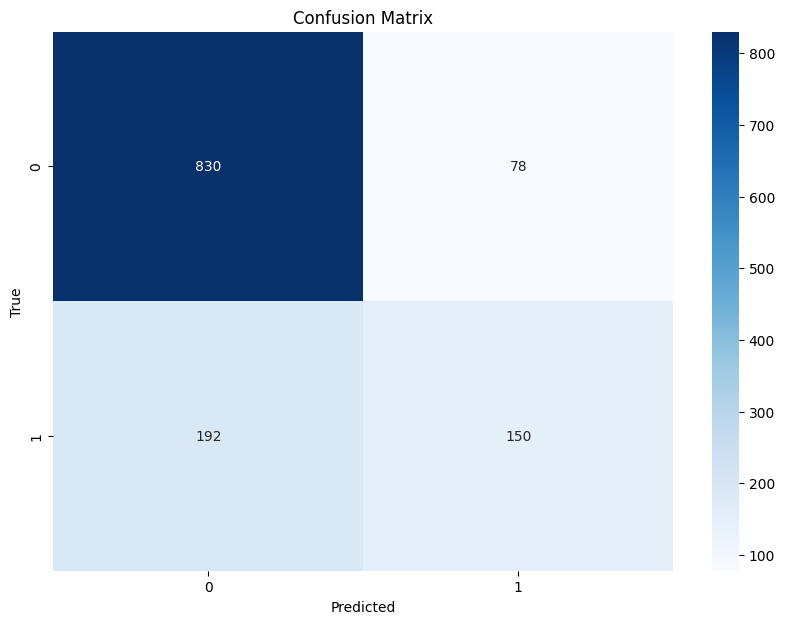

In [33]:
# Define the parameter grid for KNN Grid Search
param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'metric': ['cosine', 'euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Set up Grid Search with cross-validation, with 5 folds
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit the Grid Search model on the training data
grid_search.fit(tfidf_matrix_train_lemmatized, y_train)

# Get the best parameters and best score from Grid Search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Use the best estimator from Grid Search to make predictions on the validation data
y_pred_val = grid_search.best_estimator_.predict(tfidf_matrix_val_lemmatized)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='KNN-STEMMED'></a>
### 4.2. K-Nearest Neighbour with TF-IDF (Stemming Version)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.7631423511752826


Weighted F1 Score: 0.7660561210792348


Accuracy Score: 0.7808


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       908
           1       0.65      0.44      0.52       342

    accuracy                           0.78      1250
   macro avg       0.73      0.67      0.69      1250
weighted avg       0.77      0.78      0.77      1250



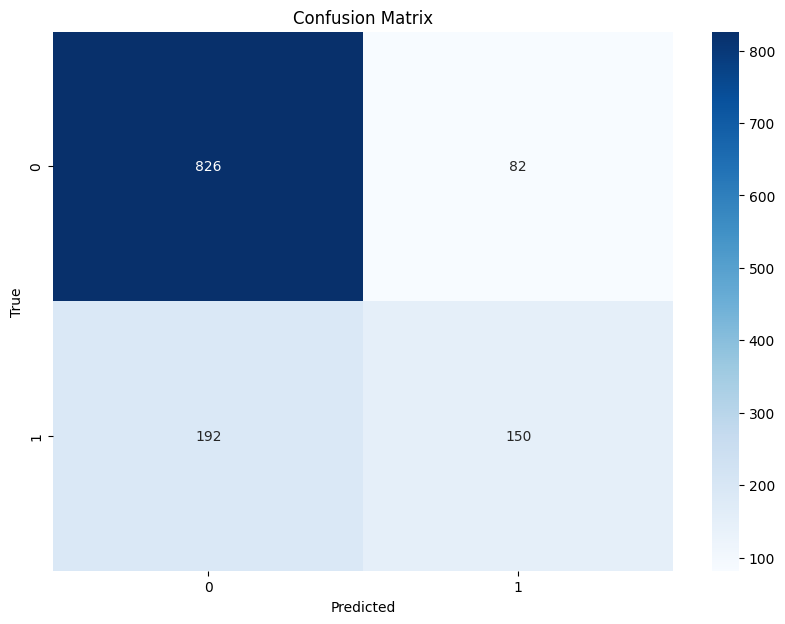

In [34]:
# Define the parameter grid for KNN Grid Search
param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'metric': ['cosine', 'euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Set up Grid Search with cross-validation, with 5 folds
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit the Grid Search model on the training data
grid_search.fit(tfidf_matrix_train_stemmed, y_train)

# Get the best parameters and best score from Grid Search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Use the best estimator from Grid Search to make predictions on the validation data
y_pred_val = grid_search.best_estimator_.predict(tfidf_matrix_val_stemmed)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='LR'></a>
### 4.3. Logistic Regression with TF-IDF (Lemmatized Version)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\sebas\anaconda3\envs\main_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.7654871175494293


Weighted F1 Score: 0.7816843116393593


Accuracy Score: 0.8016


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       908
           1       0.74      0.42      0.54       342

    accuracy                           0.80      1250
   macro avg       0.78      0.68      0.71      1250
weighted avg       0.79      0.80      0.78      1250



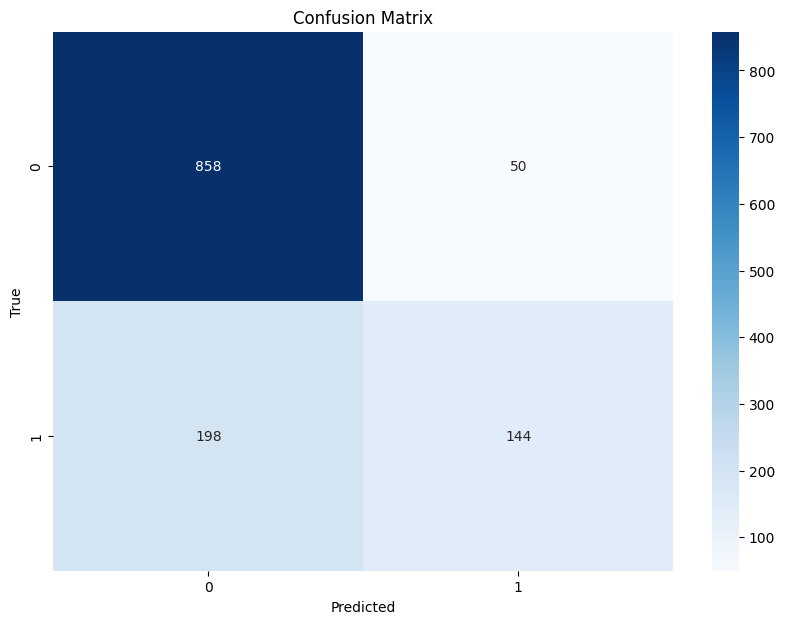

In [35]:
# Define the parameter grid for the Logistic Regression Grid Search
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'sag', 'saga'], 'max_iter': [100, 200, 500]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none'], 'solver': ['lbfgs', 'sag', 'saga'], 'max_iter': [100, 200, 500]},
]

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression()

# Set up Grid Search with cross-validation, with 5 folds
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit the Grid Search model on the training data
grid_search.fit(tfidf_matrix_train_lemmatized, y_train)

# Get the best parameters and best score from Grid Search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Use the best estimator from Grid Search to make predictions on the validation data
y_pred_val = grid_search.best_estimator_.predict(tfidf_matrix_val_lemmatized)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='LSTM'></a>
### 4.4. Multi-Input Long-Short Term Memory using GloVe Embeddings

In [36]:
# Get list with lenghts of sentences in terms of tokens, so that we can see the maximum length of the 'description' feature in the X_train dataset
desc_train_len = []
for i in X_train['description_lemmatized']:
    desc_train_len.append(len(i))

MAX_DESCRIPTION = max(desc_train_len)
print(f'The maximum number of tokens for a single property in the X_train dataset in the column description_lemmatized is {MAX_DESCRIPTION}')

The maximum number of tokens for a single property in the X_train dataset in the column description_lemmatized is 260


In [37]:
# Confirm the shape of the X_train dataset
X_train.shape

(4998, 6)

In [38]:
# This matrix full of zeros will serve for inputation in case there are empty values in the columns 'description' or 'host_about'
# It is noteworthy to mention that the 300 0s is because this corresponds to the dimension of the GloVe Embeddings
np.zeros(shape=(1,300))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [39]:
# Function to return a matrix full of zeros (the same number of 0s as the GloVe Embeddings dimension)
def zeros_matrix():
    return np.zeros(shape=(1,300))

# Function to replace empty lists with the zeros matrix
def replace_with_zeros_matrix(column):
    return column.apply(lambda x: zeros_matrix() if len(x) == 0 else x)

# Replace empty lists in 'description_lemmatized' with zero matrix, in the X_train dataset
X_train['description_lemmatized'] = replace_with_zeros_matrix(X_train['description_lemmatized'])

# Replace empty lists in 'host_about_lemmatized' with zero matrix, in the X_train dataset
X_train['host_about_lemmatized'] = replace_with_zeros_matrix(X_train['host_about_lemmatized'])


# Replace empty lists in 'description_lemmatized' with zero matrix, in the X_val dataset
X_val['description_lemmatized'] = replace_with_zeros_matrix(X_val['description_lemmatized'])

# Replace empty lists in 'host_about_lemmatized' with zero matrix, in the X_val dataset
X_val['host_about_lemmatized'] = replace_with_zeros_matrix(X_val['host_about_lemmatized'])


# Replace empty lists in 'description_lemmatized' with zero matrix, in the X_test dataset
X_test['description_lemmatized'] = replace_with_zeros_matrix(X_test['description_lemmatized'])

# Replace empty lists in 'host_about_lemmatized' with zero matrix, in the X_test dataset
X_test['host_about_lemmatized'] = replace_with_zeros_matrix(X_test['host_about_lemmatized'])

In [40]:
# Get list with lenghts of sentences in terms of tokens, so that we can see the maximum length of the 'host_about' feature in the X_train dataset
host_train_len = []
for i in X_train['host_about_lemmatized']:
    host_train_len.append(len(i))

MAX_HOST_ABOUT = max(host_train_len)
print(f'The maximum number of tokens for a single property in the X_train dataset in the column host_about_lemmatized is {MAX_HOST_ABOUT}')

The maximum number of tokens for a single property in the X_train dataset in the column host_about_lemmatized is 783


In [41]:
BITS = '16'

# Pad sequences for each input, using the max length os the max number of tokens for a single property on the X_train dataset on the two columns:
# description_lemmatized and host_about_lemmatized
X_train_description = pad_sequences(X_train['description_lemmatized'], maxlen = MAX_DESCRIPTION, dtype='float'+BITS, padding='post') 
X_train_host = pad_sequences(X_train['host_about_lemmatized'], maxlen = MAX_HOST_ABOUT, dtype='float'+BITS, padding='post') 
X_val_description = pad_sequences(X_val['description_lemmatized'], maxlen = MAX_DESCRIPTION, dtype='float'+BITS, padding='post') 
X_val_host = pad_sequences(X_val['host_about_lemmatized'], maxlen = MAX_HOST_ABOUT, dtype='float'+BITS, padding='post') 
X_test_description = pad_sequences(X_test['description_lemmatized'], maxlen = MAX_DESCRIPTION, dtype='float'+BITS, padding='post') 
X_test_host = pad_sequences(X_test['host_about_lemmatized'], maxlen = MAX_HOST_ABOUT, dtype='float'+BITS, padding='post')


# Convert to numpy arrays with float16 type
X_train_description = np.asarray(X_train_description).astype('float'+BITS)
X_train_host = np.asarray(X_train_host).astype('float'+BITS)
X_val_description = np.asarray(X_val_description).astype('float'+BITS)
X_val_host = np.asarray(X_val_host).astype('float'+BITS)
X_test_description = np.asarray(X_test_description).astype('float'+BITS)
X_test_host = np.asarray(X_test_host).astype('float'+BITS)

[I 2024-06-05 09:38:45,354] A new study created in memory with name: no-name-d245e664-d7c5-4050-9ffb-09558a62a38d


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 653ms/step - accuracy: 0.7077 - loss: 0.6455 - val_accuracy: 0.7272 - val_loss: 0.5633 - learning_rate: 0.0380
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 741ms/step - accuracy: 0.7188 - loss: 0.5620 - val_accuracy: 0.7272 - val_loss: 0.5646 - learning_rate: 0.0380
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 119s 757ms/step - accuracy: 0.7279 - loss: 0.5483 - val_accuracy: 0.7288 - val_loss: 0.5661 - learning_rate: 0.0380
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 736ms/step - accuracy: 0.7399 - loss: 0.5228 - val_accuracy: 0.7448 - val_loss: 0.5625 - learning_rate: 0.0076
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 112s 713ms/step - accuracy: 0.7570 - loss: 0.5088 - val_accuracy: 0.7432 - val_loss: 0.5600 - learning_rate: 0.0076
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 723ms/step - accuracy: 0.7676 - loss: 0.4845 - val_accuracy: 0.7464 - val_loss: 0.5476 - learning_rate: 0.0076
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 113s 716ms/step - accura

[I 2024-06-05 09:56:08,718] Trial 0 finished with value: 0.746399998664856 and parameters: {'lstm_units': 70, 'dense_units': 45, 'dropout_rate': 0.34816317891496795, 'learning_rate': 0.03801856655237004}. Best is trial 0 with value: 0.746399998664856.


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 130s 814ms/step - accuracy: 0.7126 - loss: 0.7521 - val_accuracy: 0.7264 - val_loss: 0.5892 - learning_rate: 0.0986
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 136s 863ms/step - accuracy: 0.7353 - loss: 0.5833 - val_accuracy: 0.7232 - val_loss: 0.5994 - learning_rate: 0.0986
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 877ms/step - accuracy: 0.7192 - loss: 0.5960 - val_accuracy: 0.7264 - val_loss: 0.5883 - learning_rate: 0.0986
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 901ms/step - accuracy: 0.7327 - loss: 0.5827 - val_accuracy: 0.7264 - val_loss: 0.5927 - learning_rate: 0.0986
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 901ms/step - accuracy: 0.7181 - loss: 0.6010 - val_accuracy: 0.7264 - val_loss: 0.5868 - learning_rate: 0.0986
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 900ms/step - accuracy: 0.7276 - loss: 0.5880 - val_accuracy: 0.7264 - val_loss: 0.5868 - learning_rate: 0.0986
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 874ms/step - accura

[I 2024-06-05 10:18:15,375] Trial 1 finished with value: 0.7264000177383423 and parameters: {'lstm_units': 98, 'dense_units': 29, 'dropout_rate': 0.40551165912483655, 'learning_rate': 0.09864860016033845}. Best is trial 0 with value: 0.746399998664856.


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 467ms/step - accuracy: 0.7049 - loss: 0.6356 - val_accuracy: 0.7264 - val_loss: 0.5656 - learning_rate: 0.0474
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 508ms/step - accuracy: 0.7165 - loss: 0.5729 - val_accuracy: 0.7264 - val_loss: 0.5510 - learning_rate: 0.0474
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 499ms/step - accuracy: 0.7408 - loss: 0.5303 - val_accuracy: 0.7440 - val_loss: 0.5535 - learning_rate: 0.0474
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 537ms/step - accuracy: 0.7481 - loss: 0.5252 - val_accuracy: 0.7232 - val_loss: 0.5594 - learning_rate: 0.0474
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.7586 - loss: 0.4888 - val_accuracy: 0.7536 - val_loss: 0.5534 - learning_rate: 0.0095


[I 2024-06-05 10:25:01,331] Trial 2 finished with value: 0.7264000177383423 and parameters: {'lstm_units': 75, 'dense_units': 17, 'dropout_rate': 0.14928690213809334, 'learning_rate': 0.0473802432735903}. Best is trial 0 with value: 0.746399998664856.


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 558ms/step - accuracy: 0.6962 - loss: 0.6369 - val_accuracy: 0.7400 - val_loss: 0.5489 - learning_rate: 0.0241
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 597ms/step - accuracy: 0.7352 - loss: 0.5361 - val_accuracy: 0.7400 - val_loss: 0.5552 - learning_rate: 0.0241
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 598ms/step - accuracy: 0.7617 - loss: 0.4975 - val_accuracy: 0.7656 - val_loss: 0.5407 - learning_rate: 0.0241
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 596ms/step - accuracy: 0.7751 - loss: 0.4690 - val_accuracy: 0.7520 - val_loss: 0.5664 - learning_rate: 0.0241
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 597ms/step - accuracy: 0.7911 - loss: 0.4407 - val_accuracy: 0.7624 - val_loss: 0.5458 - learning_rate: 0.0241
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 101s 640ms/step - accuracy: 0.8224 - loss: 0.3971 - val_accuracy: 0.7488 - val_loss: 0.5811 - learning_rate: 0.0048


[I 2024-06-05 10:34:37,066] Trial 3 finished with value: 0.7656000256538391 and parameters: {'lstm_units': 90, 'dense_units': 38, 'dropout_rate': 0.13324111463905913, 'learning_rate': 0.02414917466556657}. Best is trial 3 with value: 0.7656000256538391.


Number of finished trials: 4
Best trial: {'lstm_units': 90, 'dense_units': 38, 'dropout_rate': 0.13324111463905913, 'learning_rate': 0.02414917466556657}


/Users/raquelrocha/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step


F1 Score: 0.7230152587778395


Accuracy Score: 0.7656


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86       908
           1       0.70      0.25      0.37       342

    accuracy                           0.77      1250
   macro avg       0.74      0.61      0.61      1250
weighted avg       0.75      0.77      0.72      1250



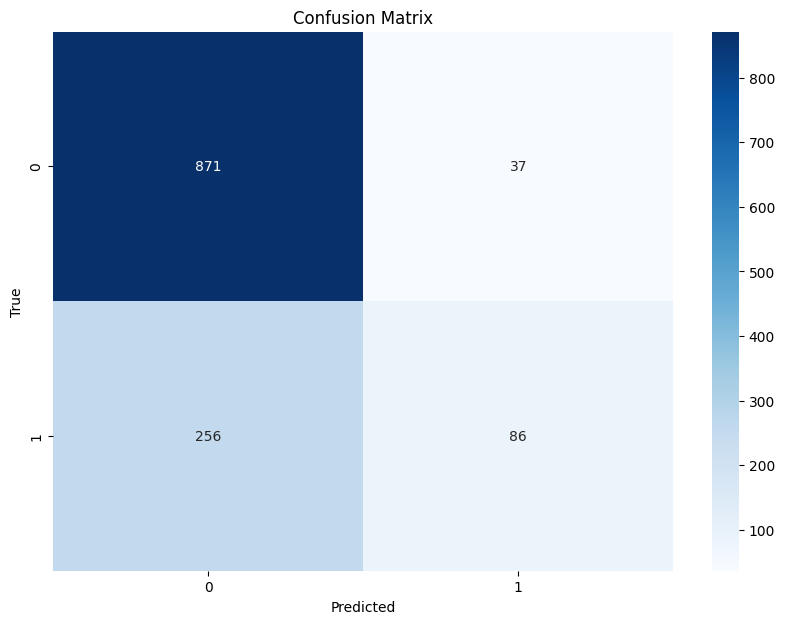

In [ ]:
def create_model(trial):
    
    # Hyperparameters to tune
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dense_units = trial.suggest_int('dense_units', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1)

    # Define the two input layers (description and host_about features)
    input1 = Input(shape=(X_train_description.shape[1], X_train_description.shape[2]))
    input2 = Input(shape=(X_train_host.shape[1], X_train_host.shape[2]))

    # mask layer to avoid model from considering padding vectors
    mask_layer = Masking(mask_value=0)
    mask_1 = mask_layer(input1)
    mask_2 = mask_layer(input2)

    # Create LSTM layers for each reshaped input
    lstm1 = LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)(mask_1)
    lstm2 = LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)(mask_2)
    
    # Concatenate the outputs of the LSTM layers
    merged = concatenate([lstm1, lstm2])
    
    # Relu Activation layer
    act = Dense(dense_units, activation='relu')(merged)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(act)

    # Create the model
    model = Model(inputs=[input1, input2], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


def objective(trial):
    
    model = create_model(trial)
    
    # Define the callbacks
    checkpoint_cb = ModelCheckpoint('best_LSTM.h5.keras', save_best_only=True, monitor='val_loss', mode='min')
    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-3, mode='min')

    history = model.fit(
        [X_train_description, X_train_host], y_train,
        validation_data=([X_val_description, X_val_host], y_val),
        epochs=10, batch_size=32, verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
    )
    
    loss, accuracy = model.evaluate([X_val_description, X_val_host], y_val, verbose=0)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Load the best model
best_model = create_model(study.best_trial)
best_model.load_weights('best_LSTM.h5.keras')

# Predict on the validation set
y_pred_val = best_model.predict([X_val_description, X_val_host])
y_pred_val = (y_pred_val > 0.5).astype(int)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='RF-1'></a>
### 4.5. EXTRA: Random Forest using Sentence Embeddings BERT Multilingual, Sentiment Analysis, Number of Reviews

In [44]:
# A reminder of how the train_reviews_with_sentence_embeddings_bert_multilingual dataset looks like
train_reviews_bert_multilingual = pd.read_csv('train_reviews_with_sentence_embeddings_bert_multilingual.csv')
train_reviews_bert_multilingual.drop('Unnamed: 0', inplace=True, axis=1)
train_reviews_bert_multilingual.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4,[-1.67620286e-01 1.27289398e-02 1.82780266e-...
1,1,['good'],cy,['good'],['good'],1,good,4,[-7.90571347e-02 3.34066540e-01 -7.97690228e-...
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3,[-2.47390106e-01 -9.89657938e-02 2.47941568e-...


In [45]:
# A reminder of how the test_reviews_with_sentence_embeddings_bert_multilingual dataset looks like
test_reviews_bert_multilingual = pd.read_csv('test_reviews_with_sentence_embeddings_bert_multilingual.csv')
test_reviews_bert_multilingual.drop('Unnamed: 0', inplace=True, axis=1)
test_reviews_bert_multilingual.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...,5,[-1.97801366e-01 -7.03575164e-02 3.61720532e-...
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...,4,[-1.21244431e-01 -1.35422006e-01 2.59434998e-...
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...,4,[-3.06668073e-01 -2.20760062e-01 2.81669110e-...


In [46]:
# Drop the unneeded columns of the train version
train_reviews_bert_multilingual = train_reviews_bert_multilingual[['property_id', 'sentiment', 'sentence_embeddings']]
train_reviews_bert_multilingual

,property_id,sentiment,sentence_embeddings
0,1,4,[-1.67620286e-01 1.27289398e-02 1.82780266e-...
1,1,4,[-7.90571347e-02 3.34066540e-01 -7.97690228e-...
2,1,3,[-2.47390106e-01 -9.89657938e-02 2.47941568e-...
3,1,4,[-2.73543715e-01 -2.60691166e-01 1.80363029e-...
4,1,4,[-2.12885261e-01 4.30643484e-02 1.22236602e-...
...,...,...,...
355999,6248,5,[-2.18787700e-01 -3.36523578e-02 3.30240667e-...
356000,6248,5,[-1.46887168e-01 -8.56535509e-02 2.89370120e-...
356001,6248,4,[-3.54044348e-01 8.79909173e-02 -5.87201379e-...
356002,6248,3,[-2.66409069e-01 3.36353220e-02 1.81061655e-...


In [47]:
# Drop the unneeded columns of the test version
test_reviews_bert_multilingual = test_reviews_bert_multilingual[['property_id', 'sentiment', 'sentence_embeddings']]
test_reviews_bert_multilingual

,property_id,sentiment,sentence_embeddings
0,1,5,[-1.97801366e-01 -7.03575164e-02 3.61720532e-...
1,1,4,[-1.21244431e-01 -1.35422006e-01 2.59434998e-...
2,1,4,[-3.06668073e-01 -2.20760062e-01 2.81669110e-...
3,1,4,[-8.51777568e-02 -2.54057556e-01 4.36906219e-...
4,1,4,[-0.19571084 -0.22247857 0.1740892 0.095998...
...,...,...,...
41262,695,5,[-4.26690951e-02 3.25034112e-01 9.31668207e-...
41263,695,4,[-2.37047344e-01 3.21746767e-01 5.36811538e-...
41264,695,4,[-1.23459637e-01 -4.25476618e-02 -8.66780523e-...
41265,695,5,[-8.35497230e-02 -8.18659645e-03 7.81618878e-...


In [48]:
# Function to clean and convert the string representation of an array to an actual array
def clean_and_convert_to_array(s):
    
    # Remove newline characters
    cleaned_str = s.replace('\n', '')
    
    # Remove the leading and trailing brackets
    cleaned_str = cleaned_str.strip('[]')
    
    # Convert the cleaned string to a numpy array
    float_array = np.fromstring(cleaned_str, sep=' ')
    return float_array

# Apply the function to the sentence_embeddings column on the train version
train_reviews_bert_multilingual['sentence_embeddings'] = train_reviews_bert_multilingual['sentence_embeddings'].apply(clean_and_convert_to_array)

In [49]:
# Apply the function to the sentence_embeddings column on the test version
test_reviews_bert_multilingual['sentence_embeddings'] = test_reviews_bert_multilingual['sentence_embeddings'].apply(clean_and_convert_to_array)

In [50]:
# Create a DataFrame with all unique property IDs present on the train dataset
properties_df = pd.DataFrame(train['property_id'].unique(), columns=['property_id'])

# Initialize the grouped data
grouped_data = {
    'property_id': [],
    'average_sentiment': [],
    'sentence_embeddings_matrix': []
}

# Group by property_id
grouped = train_reviews_bert_multilingual.groupby('property_id')

# Process each group
for property_id, group in grouped:
    
    # Compute the average sentiment by property ID
    avg_sentiment = group['sentiment'].mean()
    
    # Stack the sentence embeddings into a matrix
    embeddings_matrix = np.stack(group['sentence_embeddings'].values)
    
    # Append to the new grouped data
    grouped_data['property_id'].append(property_id)
    grouped_data['average_sentiment'].append(avg_sentiment)
    grouped_data['sentence_embeddings_matrix'].append(embeddings_matrix)


# Create the new DataFrame with the grouped data
grouped_reviews_df = pd.DataFrame(grouped_data)

# Perform a left join with the properties_df to include all properties
train_reviews_grouped_bert = properties_df.merge(grouped_reviews_df, on='property_id', how='left')

# Display the new DataFrame
train_reviews_grouped_bert

,property_id,average_sentiment,sentence_embeddings_matrix
0,1,4.285714,"[[-0.167620286, 0.0127289398, 0.182780266, 0.0..."
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,4.829268,"[[-0.0911251158, -0.0495219305, 0.160064459, 0..."
...,...,...,...
6243,6244,4.828283,"[[-0.140101239, 0.136886194, 0.12519221, 0.076..."
6244,6245,4.531746,"[[-0.164202735, -0.117728554, 0.223880187, 0.0..."
6245,6246,4.208333,"[[-0.0736792684, -0.00615373719, 0.131613269, ..."
6246,6247,4.200000,"[[0.00158827542, 0.194220304, 0.343871802, -0...."


In [51]:
# Create a DataFrame with all unique property IDs on the test dataset
properties_df = pd.DataFrame(test['property_id'].unique(), columns=['property_id'])

# Initialize the grouped data
grouped_data = {
    'property_id': [],
    'average_sentiment': [],
    'sentence_embeddings_matrix': []
}

# Group by property_id
grouped = test_reviews_bert_multilingual.groupby('property_id')

# Process each group
for property_id, group in grouped:
    
    # Compute the average sentiment by property ID
    avg_sentiment = group['sentiment'].mean()
    
    # Stack the sentence embeddings into a matrix
    embeddings_matrix = np.stack(group['sentence_embeddings'].values)
    
    # Append to the new grouped data
    grouped_data['property_id'].append(property_id)
    grouped_data['average_sentiment'].append(avg_sentiment)
    grouped_data['sentence_embeddings_matrix'].append(embeddings_matrix)


# Create the new DataFrame with the grouped data
grouped_reviews_df = pd.DataFrame(grouped_data)

# Perform a left join with the properties_df to include all properties
test_reviews_grouped_bert = properties_df.merge(grouped_reviews_df, on='property_id', how='left')

# Display the new DataFrame
test_reviews_grouped_bert

,property_id,average_sentiment,sentence_embeddings_matrix
0,1,4.409836,"[[-0.197801366, -0.0703575164, 0.361720532, -0..."
1,2,4.454545,"[[-0.236551151, -0.114964366, 0.318528354, 0.3..."
2,3,NaN,NaN
3,4,4.823529,"[[-0.257873118, -0.0487708449, 0.259088844, 0...."
4,5,4.285714,"[[-0.205568686, -0.135420591, 0.20307979, 0.39..."
...,...,...,...
690,691,4.743119,"[[-0.150367975, -0.196415499, 0.255271137, 0.2..."
691,692,4.485437,"[[-0.206408784, -0.160882473, 0.0290600471, -0..."
692,693,NaN,NaN
693,694,4.495050,"[[-0.273294955, -0.21659407, 0.267496854, -0.1..."


In [52]:
# Select the 'property_id' and 'unlisted' columns from the train dataframe
unlisted_data = train[['property_id', 'unlisted']]

# Merge the unlisted target information into the train_reviews_grouped_bert dataframe
train_reviews_grouped_bert = train_reviews_grouped_bert.merge(unlisted_data, on='property_id', how='left')

# Display the new dataframe
train_reviews_grouped_bert

,property_id,average_sentiment,sentence_embeddings_matrix,unlisted
0,1,4.285714,"[[-0.167620286, 0.0127289398, 0.182780266, 0.0...",0
1,2,NaN,NaN,1
2,3,NaN,NaN,1
3,4,NaN,NaN,0
4,5,4.829268,"[[-0.0911251158, -0.0495219305, 0.160064459, 0...",0
...,...,...,...,...
6243,6244,4.828283,"[[-0.140101239, 0.136886194, 0.12519221, 0.076...",0
6244,6245,4.531746,"[[-0.164202735, -0.117728554, 0.223880187, 0.0...",0
6245,6246,4.208333,"[[-0.0736792684, -0.00615373719, 0.131613269, ...",1
6246,6247,4.200000,"[[0.00158827542, 0.194220304, 0.343871802, -0....",0


In [53]:
# Drop datasets that are not needed any longer due to RAM constraints
del train_reviews_bert_multilingual
del test_reviews_bert_multilingual

In [54]:
# Function to count the number of reviews per property
def count_reviews(matrix):
    if isinstance(matrix, np.ndarray):
        return matrix.shape[0]
    else:
        return 0

# Function to impute the missing sentence_embeddings_matrix with an array composed only of 1,000 values
def impute_matrix(matrix):
    if isinstance(matrix, np.ndarray):
        return matrix
    else:
        return np.full((1, 768), 1_000)

# Apply to the train dataset
train_reviews_grouped_bert['number_of_reviews'] = train_reviews_grouped_bert['sentence_embeddings_matrix'].apply(count_reviews)
train_reviews_grouped_bert['sentence_embeddings_matrix'] = train_reviews_grouped_bert['sentence_embeddings_matrix'].apply(impute_matrix)

# Imput the missing values in the average sentiment feature with 0 
train_reviews_grouped_bert['average_sentiment'].fillna(0, inplace=True)


# Apply to the test dataset
test_reviews_grouped_bert['number_of_reviews'] = test_reviews_grouped_bert['sentence_embeddings_matrix'].apply(count_reviews)
test_reviews_grouped_bert['sentence_embeddings_matrix'] = test_reviews_grouped_bert['sentence_embeddings_matrix'].apply(impute_matrix)

# Imput the missing values in the average sentiment feature with 0
test_reviews_grouped_bert['average_sentiment'].fillna(0, inplace=True)

In [55]:
# Function to compute the average of each column in the sentence_embeddings_matrix
def compute_column_averages(matrix):
    if isinstance(matrix, np.ndarray):
        return np.mean(matrix, axis=0)

# Compute the column averages for the train dataset
train_reviews_grouped_bert['embeddings_avg'] = train_reviews_grouped_bert['sentence_embeddings_matrix'].apply(compute_column_averages)

# Expand the embeddings_avg column to 768 new columns
embeddings_avg_df_train = pd.DataFrame(train_reviews_grouped_bert['embeddings_avg'].tolist(), index=train_reviews_grouped_bert.index)
embeddings_avg_df_train.columns = [f'embedding_{i}' for i in range(768)]

# Concatenate the new columns to the original train dataframe
train_reviews_grouped_bert = pd.concat([train_reviews_grouped_bert, embeddings_avg_df_train], axis=1)
train_reviews_grouped_bert.drop(columns=['embeddings_avg'], inplace=True)


# Compute the column averages for the test dataset
test_reviews_grouped_bert['embeddings_avg'] = test_reviews_grouped_bert['sentence_embeddings_matrix'].apply(compute_column_averages)

# Expand the embeddings_avg column to 768 new columns
embeddings_avg_df_test = pd.DataFrame(test_reviews_grouped_bert['embeddings_avg'].tolist(), index=test_reviews_grouped_bert.index)
embeddings_avg_df_test.columns = [f'embedding_{i}' for i in range(768)]

# Concatenate the new columns to the original test dataframe
test_reviews_grouped_bert = pd.concat([test_reviews_grouped_bert, embeddings_avg_df_test], axis=1)
test_reviews_grouped_bert.drop(columns=['embeddings_avg'], inplace=True)

In [56]:
# Dropping the unnecessary columns for the Random Forest Classifier
train_reviews_grouped_bert.drop(['property_id', 'sentence_embeddings_matrix'], axis=1, inplace=True)
test_reviews_grouped_bert.drop(['property_id', 'sentence_embeddings_matrix'], axis=1, inplace=True)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Weighted F1 Score: 0.862913357701271


Accuracy Score: 0.8592


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       908
           1       0.70      0.85      0.77       342

    accuracy                           0.86      1250
   macro avg       0.82      0.85      0.83      1250
weighted avg       0.87      0.86      0.86      1250



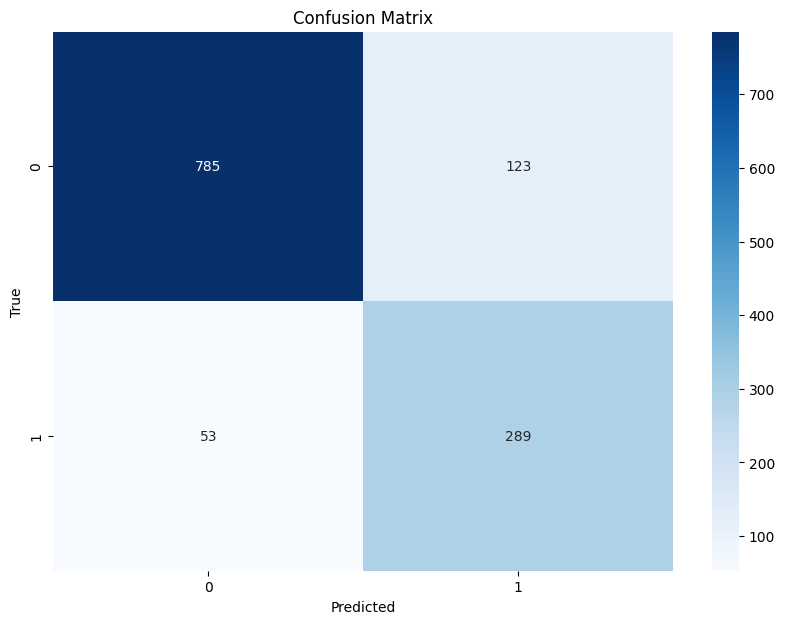

In [57]:
# Split the training data into train (80%) and validation (20%) sets
X = train_reviews_grouped_bert.drop('unlisted', axis=1)
y = train_reviews_grouped_bert['unlisted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Apply Grid-Search with cross-validation, with 3 folds due to time constraints
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the validation set
y_pred_val = best_model.predict(X_val)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='RF-2'></a>
### 4.6. EXTRA: Random Forest using Sentence Embeddings XLM-RoBERTa Multilingual, Sentiment Analysis, Number of Reviews

In [58]:
# A reminder of how the train_reviews_with_sentence_embeddings_xlm_roberta dataset looks like
train_reviews_xlm_roberta = pd.read_csv('train_reviews_with_sentence_embeddings_xlm_roberta.csv')
train_reviews_xlm_roberta.drop('Unnamed: 0', inplace=True, axis=1)
train_reviews_xlm_roberta.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['cozy', 'comfortable', 'house', 'stay', 'inne...",en,"['cozy', 'comfortable', 'house', 'stay', 'inne...","['cozi', 'comfort', 'hous', 'stay', 'innev', '...",14,cozy comfortable house stay innever worry safe...,4,[ 2.10878886e-02 7.53354505e-02 1.02234771e-...
1,1,['good'],cy,['good'],['good'],1,good,4,[ 5.68449795e-02 8.66433159e-02 -5.98521531e-...
2,1,"['first', 'hostel', 'experience', 'say', 'pret...",en,"['first', 'hostel', 'experience', 'say', 'pret...","['first', 'hostel', 'experi', 'say', 'pretti',...",136,first hostel experience say pretty hard beat p...,3,[ 1.83549197e-03 6.21708930e-02 8.66620149e-...


In [59]:
# A reminder of how the test_reviews_with_sentence_embeddings_xlm_roberta dataset looks like
test_reviews_xlm_roberta = pd.read_csv('test_reviews_with_sentence_embeddings_xlm_roberta.csv')
test_reviews_xlm_roberta.drop('Unnamed: 0', inplace=True, axis=1)
test_reviews_xlm_roberta.head(3)

,property_id,comments,language,comments_lemmatized,comments_stemmed,review_length,concatenated_comments,sentiment,sentence_embeddings
0,1,"['thank', 'much', 'antonio', 'perfect', 'stay'...",en,"['thank', 'much', 'antonio', 'perfect', 'stay'...","['thank', 'much', 'antonio', 'perfect', 'stay'...",16,thank much antonio perfect stay appartment per...,5,[-2.94359941e-02 4.39671502e-02 2.65786033e-...
1,1,"['nice', 'appartment', 'old', 'town', 'lissabo...",en,"['nice', 'appartment', 'old', 'town', 'lissabo...","['nice', 'appart', 'old', 'town', 'lissabon', ...",27,nice appartment old town lissabon quite centra...,4,[-1.17255347e-02 7.57097825e-02 1.45307099e-...
2,1,"['travelling', 'looking', 'kids', 'friendly', ...",en,"['travel', 'look', 'kid', 'friendly', 'place',...","['travel', 'look', 'kid', 'friend', 'place', '...",58,travel look kid friendly place stay antonio pl...,4,[-5.94652165e-03 7.65267387e-02 -2.77041038e-...


In [60]:
# Drop the unneeded columns of the train version
train_reviews_xlm_roberta = train_reviews_xlm_roberta[['property_id', 'sentiment', 'sentence_embeddings']]
train_reviews_xlm_roberta

,property_id,sentiment,sentence_embeddings
0,1,4,[ 2.10878886e-02 7.53354505e-02 1.02234771e-...
1,1,4,[ 5.68449795e-02 8.66433159e-02 -5.98521531e-...
2,1,3,[ 1.83549197e-03 6.21708930e-02 8.66620149e-...
3,1,4,[ 2.78875884e-02 5.65331243e-02 1.39032127e-...
4,1,4,[-2.90077757e-02 4.94807884e-02 2.49786116e-...
...,...,...,...
355999,6248,5,[ 4.45997417e-02 9.05984566e-02 1.30274231e-...
356000,6248,5,[-2.68190796e-03 4.51950990e-02 2.15778016e-...
356001,6248,4,[ 2.62707397e-02 7.54417926e-02 2.62151212e-...
356002,6248,3,[ 2.16564722e-02 6.99182153e-02 2.16143299e-...


In [61]:
# Drop the unneeded columns of the test version
test_reviews_xlm_roberta = test_reviews_xlm_roberta[['property_id', 'sentiment', 'sentence_embeddings']]
test_reviews_xlm_roberta

,property_id,sentiment,sentence_embeddings
0,1,5,[-2.94359941e-02 4.39671502e-02 2.65786033e-...
1,1,4,[-1.17255347e-02 7.57097825e-02 1.45307099e-...
2,1,4,[-5.94652165e-03 7.65267387e-02 -2.77041038e-...
3,1,4,[ 3.29788066e-02 5.98814115e-02 9.60643310e-...
4,1,4,[-4.41641640e-03 5.61433658e-02 -5.46291936e-...
...,...,...,...
41262,695,5,[ 2.33635791e-02 6.33540675e-02 3.74454185e-...
41263,695,4,[ 4.33157571e-02 8.31333026e-02 9.84218437e-...
41264,695,4,[ 6.74543902e-02 7.93174133e-02 5.60917631e-...
41265,695,5,[ 2.21316405e-02 5.96139580e-02 -4.47469205e-...


In [62]:
# Function to clean and convert the string representation of an array to an actual array
def clean_and_convert_to_array(s):
    
    # Remove newline characters
    cleaned_str = s.replace('\n', '')
    
    # Remove the leading and trailing brackets
    cleaned_str = cleaned_str.strip('[]')
    
    # Convert the cleaned string to a numpy array
    float_array = np.fromstring(cleaned_str, sep=' ')
    
    return float_array

# Apply the function to the sentence_embeddings column in the train version
train_reviews_xlm_roberta['sentence_embeddings'] = train_reviews_xlm_roberta['sentence_embeddings'].apply(clean_and_convert_to_array)

In [63]:
# Apply the function to the sentence_embeddings column in the test version
test_reviews_xlm_roberta['sentence_embeddings'] = test_reviews_xlm_roberta['sentence_embeddings'].apply(clean_and_convert_to_array)

In [64]:
# Create a DataFrame with all unique property IDs in the train dataset
properties_df = pd.DataFrame(train['property_id'].unique(), columns=['property_id'])

# Initialize the grouped data
grouped_data = {
    'property_id': [],
    'average_sentiment': [],
    'sentence_embeddings_matrix': []
}

# Group by property_id
grouped = train_reviews_xlm_roberta.groupby('property_id')

# Process each group
for property_id, group in grouped:
    
    # Compute the average sentiment by property ID
    avg_sentiment = group['sentiment'].mean()
    
    # Stack the sentence embeddings into a matrix
    embeddings_matrix = np.stack(group['sentence_embeddings'].values)
    
    # Append to the new grouped data
    grouped_data['property_id'].append(property_id)
    grouped_data['average_sentiment'].append(avg_sentiment)
    grouped_data['sentence_embeddings_matrix'].append(embeddings_matrix)


# Create the new DataFrame with the grouped data
grouped_reviews_df = pd.DataFrame(grouped_data)

# Perform a left join with the properties_df to include all properties
train_reviews_grouped_roberta = properties_df.merge(grouped_reviews_df, on='property_id', how='left')

# Display the new DataFrame
train_reviews_grouped_roberta

,property_id,average_sentiment,sentence_embeddings_matrix
0,1,4.285714,"[[0.0210878886, 0.0753354505, 0.0102234771, 0...."
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,4.829268,"[[0.020818159, 0.061623089, 0.0353157371, 0.05..."
...,...,...,...
6243,6244,4.828283,"[[0.0382836834, 0.0820985958, 0.0381796807, 0...."
6244,6245,4.531746,"[[-0.0285294857, 0.0432356596, 0.0283168815, 0..."
6245,6246,4.208333,"[[0.00918517634, 0.0830524489, 0.0197166763, 0..."
6246,6247,4.200000,"[[0.0151961362, 0.114412718, 0.0180074535, 0.0..."


In [65]:
# Create a DataFrame with all unique property IDs in the test dataset
properties_df = pd.DataFrame(test['property_id'].unique(), columns=['property_id'])

# Initialize the grouped data
grouped_data = {
    'property_id': [],
    'average_sentiment': [],
    'sentence_embeddings_matrix': []
}

# Group by property_id
grouped = test_reviews_xlm_roberta.groupby('property_id')

# Process each group
for property_id, group in grouped:
    
    # Compute the average sentiment by property ID
    avg_sentiment = group['sentiment'].mean()
    
    # Stack the sentence embeddings into a matrix
    embeddings_matrix = np.stack(group['sentence_embeddings'].values)
    
    # Append to the new grouped data
    grouped_data['property_id'].append(property_id)
    grouped_data['average_sentiment'].append(avg_sentiment)
    grouped_data['sentence_embeddings_matrix'].append(embeddings_matrix)
    

# Create the new DataFrame with the grouped data
grouped_reviews_df = pd.DataFrame(grouped_data)

# Perform a left join with the properties_df to include all properties
test_reviews_grouped_roberta = properties_df.merge(grouped_reviews_df, on='property_id', how='left')

# Display the new DataFrame
test_reviews_grouped_roberta

,property_id,average_sentiment,sentence_embeddings_matrix
0,1,4.409836,"[[-0.0294359941, 0.0439671502, 0.0265786033, 0..."
1,2,4.454545,"[[-0.000867126859, 0.0437077768, 0.0212257449,..."
2,3,NaN,NaN
3,4,4.823529,"[[-0.0186554901, 0.0554920696, -0.00441400521,..."
4,5,4.285714,"[[0.0284731388, 0.0307200886, 0.0339970849, 0...."
...,...,...,...
690,691,4.743119,"[[0.00994162261, 0.0554485843, -0.000533290033..."
691,692,4.485437,"[[0.00415791338, 0.067198649, 0.0166154783, 0...."
692,693,NaN,NaN
693,694,4.495050,"[[-0.00305608823, 0.0409740657, 0.0296795331, ..."


In [66]:
# Select the 'property_id' and 'unlisted' columns from the train dataframe
unlisted_data = train[['property_id', 'unlisted']]

# Merge the unlisted target information into the train_reviews_grouped_roberta dataframe
train_reviews_grouped_roberta = train_reviews_grouped_roberta.merge(unlisted_data, on='property_id', how='left')

# Display the new dataframe
train_reviews_grouped_roberta

,property_id,average_sentiment,sentence_embeddings_matrix,unlisted
0,1,4.285714,"[[0.0210878886, 0.0753354505, 0.0102234771, 0....",0
1,2,NaN,NaN,1
2,3,NaN,NaN,1
3,4,NaN,NaN,0
4,5,4.829268,"[[0.020818159, 0.061623089, 0.0353157371, 0.05...",0
...,...,...,...,...
6243,6244,4.828283,"[[0.0382836834, 0.0820985958, 0.0381796807, 0....",0
6244,6245,4.531746,"[[-0.0285294857, 0.0432356596, 0.0283168815, 0...",0
6245,6246,4.208333,"[[0.00918517634, 0.0830524489, 0.0197166763, 0...",1
6246,6247,4.200000,"[[0.0151961362, 0.114412718, 0.0180074535, 0.0...",0


In [67]:
# Drop datasets that are not needed any longer due to RAM constraints
del train_reviews_xlm_roberta
del test_reviews_xlm_roberta

In [68]:
# Function to count the number of reviews per property
def count_reviews(matrix):
    if isinstance(matrix, np.ndarray):
        return matrix.shape[0]
    else:
        return 0

# Function to impute the missing sentence_embeddings_matrix with an array composed only of 1,000 values
def impute_matrix(matrix):
    if isinstance(matrix, np.ndarray):
        return matrix
    else:
        return np.full((1, 768), 1_000)

# Apply to the train dataset
train_reviews_grouped_roberta['number_of_reviews'] = train_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(count_reviews)
train_reviews_grouped_roberta['sentence_embeddings_matrix'] = train_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(impute_matrix)

# Input the missing values in the average sentiment feature with 0
train_reviews_grouped_roberta['average_sentiment'].fillna(0, inplace=True)


# Apply to the test dataset
test_reviews_grouped_roberta['number_of_reviews'] = test_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(count_reviews)
test_reviews_grouped_roberta['sentence_embeddings_matrix'] = test_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(impute_matrix)

# Input the missing values in the average sentiment feature with 0
test_reviews_grouped_roberta['average_sentiment'].fillna(0, inplace=True)

In [69]:
# Function to compute the average of each column in the sentence_embeddings_matrix
def compute_column_averages(matrix):
    if isinstance(matrix, np.ndarray):
        return np.mean(matrix, axis=0)

# Compute the column averages for the train dataset
train_reviews_grouped_roberta['embeddings_avg'] = train_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(compute_column_averages)

# Expand the embeddings_avg column to 768 new columns
embeddings_avg_df_train = pd.DataFrame(train_reviews_grouped_roberta['embeddings_avg'].tolist(), index=train_reviews_grouped_roberta.index)
embeddings_avg_df_train.columns = [f'embedding_{i}' for i in range(768)]

# Concatenate the new columns to the original train dataframe
train_reviews_grouped_roberta = pd.concat([train_reviews_grouped_roberta, embeddings_avg_df_train], axis=1)
train_reviews_grouped_roberta.drop(columns=['embeddings_avg'], inplace=True)

# Compute the column averages for the test dataset
test_reviews_grouped_roberta['embeddings_avg'] = test_reviews_grouped_roberta['sentence_embeddings_matrix'].apply(compute_column_averages)

# Expand the embeddings_avg column to 768 new columns
embeddings_avg_df_test = pd.DataFrame(test_reviews_grouped_roberta['embeddings_avg'].tolist(), index=test_reviews_grouped_roberta.index)
embeddings_avg_df_test.columns = [f'embedding_{i}' for i in range(768)]

# Concatenate the new columns to the original test dataframe
test_reviews_grouped_roberta = pd.concat([test_reviews_grouped_roberta, embeddings_avg_df_test], axis=1)
test_reviews_grouped_roberta.drop(columns=['embeddings_avg'], inplace=True)

In [70]:
# Dropping the unnecessary columns for the Random Forest Classifier
train_reviews_grouped_roberta.drop(['property_id', 'sentence_embeddings_matrix'], axis=1, inplace=True)
test_reviews_grouped_roberta.drop(['property_id', 'sentence_embeddings_matrix'], axis=1, inplace=True)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


Weighted F1 Score: 0.862913357701271


Accuracy Score: 0.8592


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       908
           1       0.70      0.85      0.77       342

    accuracy                           0.86      1250
   macro avg       0.82      0.85      0.83      1250
weighted avg       0.87      0.86      0.86      1250



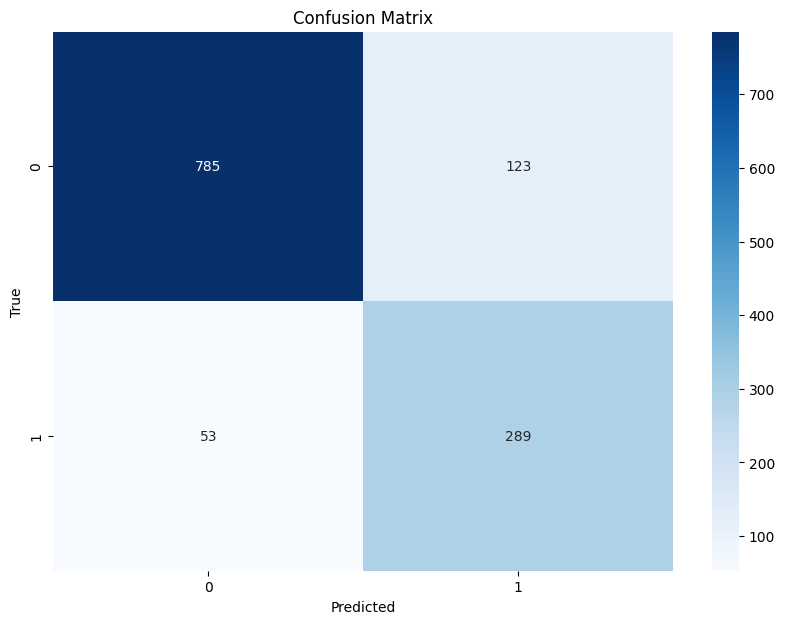

In [71]:
# Split the training data into train (80%) and validation (20%) sets
X = train_reviews_grouped_roberta.drop('unlisted', axis=1)
y = train_reviews_grouped_roberta['unlisted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Apply Grid-Search with cross-validation, with 3 folds due to time constraints
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the validation set
y_pred_val = best_model.predict(X_val)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='Ensemble'></a>
### 4.7. EXTRA: Stacking Ensemble Classifier

**Since the Random Forest Classifiers done in 4.6 exhibited exactly equivalent performance results between the two Transformer-based Sentence Embeddings (BERT and XLM-RoBERTa), we decided to only execute a Stacking Ensemble Classifier using the Sentence Embeddings from XLM-RoBERTa, Sentiment Analysis and Number of Reviews**

In [72]:
# Separate features and target
X = train_reviews_grouped_roberta.drop(columns=['unlisted'])  
y = train_reviews_grouped_roberta['unlisted']

# Perform the train (80%) and validation (20%) split, stratified by the unlisted target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [73]:
# Reset all the indices in the datasets
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [74]:
# Min-max scaling all the features
scaler_stacking = MinMaxScaler()
X_train = scaler_stacking.fit_transform(X_train)
X_val = scaler_stacking.transform(X_val)

In [75]:
# Check the success of the normalzation in the train dataset
X_train

array([[9.35483871e-01, 7.07762557e-02, 4.36072750e-05, ...,
        2.43655027e-04, 6.17503450e-05, 1.08669493e-04],
       [9.11111111e-01, 2.67123288e-01, 4.95852761e-05, ...,
        2.39021925e-04, 6.04600915e-05, 1.26677438e-04],
       [8.91525424e-01, 6.73515982e-02, 4.87970089e-05, ...,
        2.19386761e-04, 5.63010238e-05, 1.24729703e-04],
       ...,
       [9.53846154e-01, 1.33561644e-01, 4.23215132e-05, ...,
        2.73741926e-04, 6.46374919e-05, 1.29661791e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.81818182e-01, 1.25570776e-02, 4.63553136e-05, ...,
        2.49262373e-04, 6.92771990e-05, 9.89748270e-05]])

In [76]:
# Check the success of the normalzation in the validation dataset
X_val

array([[9.01904762e-01, 2.39726027e-01, 5.41808879e-05, ...,
        2.33210602e-04, 6.32027113e-05, 1.31122064e-04],
       [8.00000000e-01, 2.28310502e-03, 3.61256055e-05, ...,
        2.24219354e-04, 7.34008138e-05, 2.04519325e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [9.14285714e-01, 1.59817352e-02, 4.33307676e-05, ...,
        2.43693384e-04, 6.49088662e-05, 1.40234996e-04],
       [9.31250000e-01, 1.82648402e-01, 4.58273809e-05, ...,
        2.52585759e-04, 6.25669114e-05, 1.28696432e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [77]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
4993    0
4994    0
4995    0
4996    1
4997    0
Name: unlisted, Length: 4998, dtype: int64



Weighted F1 Score: 0.862913357701271


Accuracy Score: 0.8592


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       908
           1       0.70      0.85      0.77       342

    accuracy                           0.86      1250
   macro avg       0.82      0.85      0.83      1250
weighted avg       0.87      0.86      0.86      1250



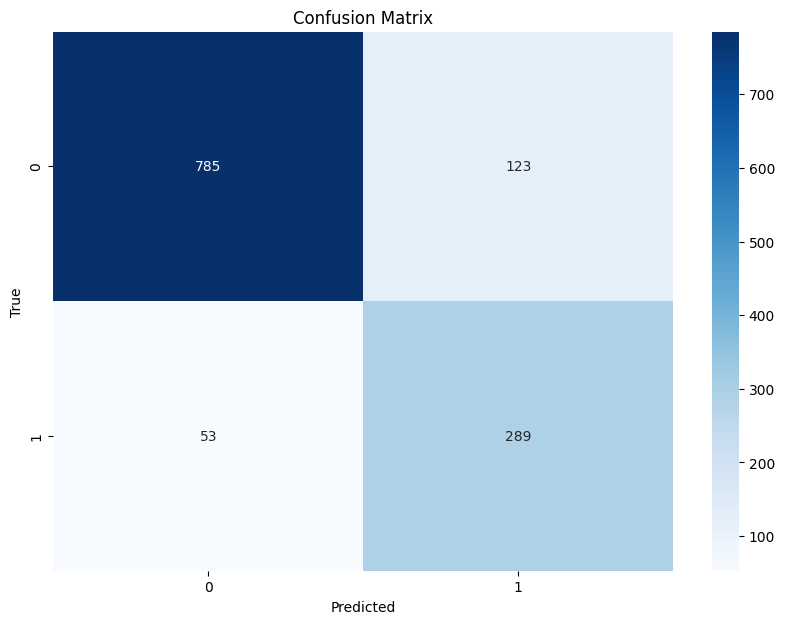

In [78]:
# Define the base models
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000, random_state=42)
mlp = MLPClassifier(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
nb = GaussianNB()
svm = SVC(probability=True, random_state=42)


# Define the stacking ensemble model
estimators = [
    ('knn', knn),
    ('lr', lr),
    ('mlp', mlp),
    ('rf', rf),
    ('nb', nb),
    ('svm', svm)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = stacking_model.predict(X_val)

# Calculate the F1 score and accuracy score
f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)

# Generate a classification report
report = classification_report(y_val, y_pred_val)

# Print the F1 score, accuracy score, and classification report
print('\n')
print(f"Weighted F1 Score: {f1}")
print('\n')
print(f"Accuracy Score: {accuracy}")
print('\n')
print("Classification Report:\n", report)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id='Final-Predictions'></a>
# 5. Predictions on the Test data

Since all these 3 models:

    1) EXTRA: Random Forest using Sentence Embeddings BERT Multilingual, Sentiment Analysis, Number of Reviews
    2) EXTRA: Random Forest using Sentence Embeddings XLM-RoBERTa (base-sized model), Sentiment Analysis, Number of Reviews
    3) EXTRA: Stacking Ensemble Classifier

Exhibited the best results (and they all performed equally the same) it was decided to use the **EXTRA: Random Forest using Sentence Embeddings XLM-RoBERTa (base-sized model), Sentiment Analysis, Number of Reviews** model for predicting on the Test data because it is a simpler model compared to the Stacking Ensemble and performs exactly the same as it's other version using the BERT Sentence Embeddings.

In [44]:
# A reminder of how the test dataset with the XLM-RoBERTa Embeddings look like
test_reviews_grouped_roberta

,average_sentiment,number_of_reviews,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,4.409836,122,-0.000651,0.061543,0.018559,0.027457,0.047904,-0.067470,-0.018308,0.055930,...,0.002678,-0.012093,0.010240,0.021877,-0.045193,-0.025079,0.087150,0.055188,0.019428,0.090573
1,4.454545,11,0.003908,0.049044,0.021686,0.036211,0.056449,-0.063517,-0.022174,0.051205,...,0.004492,0.001813,0.007123,0.039844,-0.037117,-0.026212,0.093632,0.025802,0.027149,0.056390
2,0.000000,0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
3,4.823529,17,0.000768,0.073227,0.021890,0.021955,0.050054,-0.068009,-0.019779,0.036625,...,0.012168,-0.008222,0.008732,0.035502,-0.037433,-0.022010,0.093959,0.037215,0.013521,0.085782
4,4.285714,49,0.018412,0.059966,0.025687,0.033195,0.044212,-0.052014,-0.013291,0.066237,...,-0.009952,-0.005564,0.010996,0.021231,-0.031043,-0.029871,0.117229,0.013850,0.022170,0.071601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,4.743119,109,0.004225,0.057885,0.022635,0.035000,0.044711,-0.065938,-0.017613,0.065327,...,0.007216,-0.001130,0.005590,0.025933,-0.044943,-0.022125,0.082059,0.073005,0.034093,0.084530
691,4.485437,103,0.003587,0.057497,0.021114,0.031180,0.057638,-0.060592,-0.022479,0.035738,...,0.014773,-0.010585,0.007889,0.030389,-0.035092,-0.030948,0.092105,0.037239,0.020340,0.062741
692,0.000000,0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
693,4.495050,101,0.007803,0.059354,0.020235,0.024920,0.054373,-0.061439,-0.013995,0.065006,...,0.000095,0.008840,0.008537,0.031685,-0.046692,-0.029062,0.095615,0.039343,0.021504,0.080398


In [43]:
# Perform predictions on the test dataset using the best model with the best hyperparameters
y_pred_test = best_model.predict(test_reviews_grouped_roberta)

# Create a new DataFrame with the index and the predictions
predictions_df = pd.DataFrame({
    'index': test_reviews_grouped_roberta.index,
    'predicted': y_pred_test
})

# Set the index column to be the same as the original test dataset
predictions_df.set_index('index', inplace=True)

# Export the DataFrame to a CSV file
predictions_df.to_csv('Predictions_02.csv')

print("Predictions have been saved to 'Predictions_02.csv'")

Predictions have been saved to 'Predictions_02.csv'


<a id='Conclusion'></a>
# 6. Conclusion